In [54]:
library(showtext)
showtext_auto()
library("rjags")
library(BayesianTools)
library(magrittr)
library(cowplot)
library(tidyverse)
library(latex2exp)
#https://bookdown.org/steve_midway/BHME/Ch4.html

set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

# Data set 1

In [55]:
data_ACC <- read.table("data/IC48A_AmCsCo.txt", col.names = c('Ch', 'counts')) 


## Visualization

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

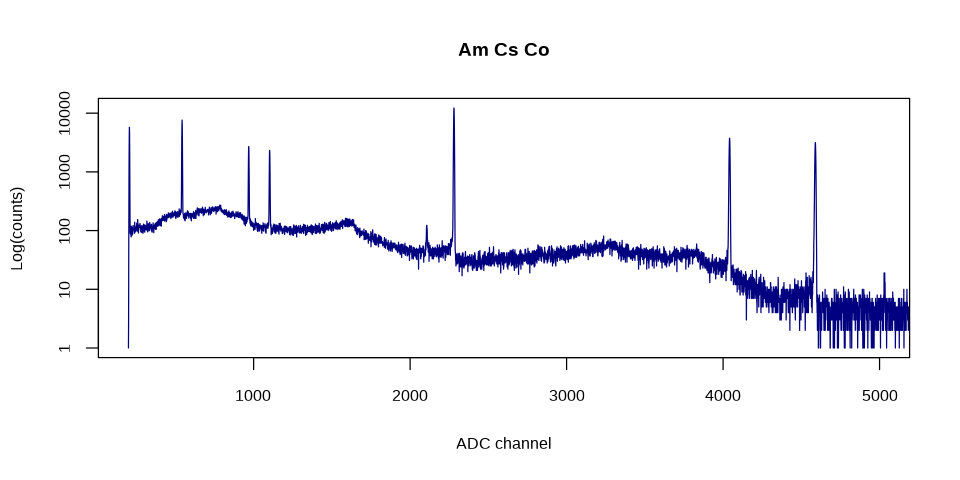

In [56]:
set_plot_dimensions(8, 4)

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(200,5000),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")


## Additional  Information

In [57]:
ACC_energies <-c(59.5409, 661.657, 1173.228, 1332.492,2505.69)
df_ACC <- data.frame(ACC_energies)
row.names(df_ACC)<-c("Am","Cs","Co_1","Co_2","Co_3")
df_ACC


ACC_energies
Am     59.5409   
Cs    661.6570   
Co_1 1173.2280   
Co_2 1332.4920   
Co_3 2505.6900

## Peak detection and characterization

Make sure to check the arguments of ```probe_peaks```

In [58]:
#Functions to probe peaks and output dataframe with each peak centered and presented as a column.

range_size <- function(data){
    #finds the size of the range of a particular chunk of data
    return(max(data) - min(data))    
}
############ New function ##############
grab_peak <- function(segment, data, peak_width){
    
    #finds the Ch corresponding to the maximum no. of counts
    peak_ch <- filter(segment, counts == max(counts))$Ch
    
    #slices the original dataframe symmetrically around the channel found with filter()
    peak_data <- data[(peak_ch - peak_width%/%2):(peak_ch + peak_width%/%2),]
    return(peak_data)
}


probe_peaks <- function(data, search_width, pk_size, peak_width = 20){

    peaks_list <- NULL
    counter <- 0
    for(i in seq(0, length(data$counts) - search_width, search_width)){
        
        #set up a data segment of (search_width) points to search over
        segment <- data[i:(i + search_width),]
        
        #Convert to log in case the count is too large
        log_counts <- sapply(segment$counts, log)
        
        segment$counts[which(!is.finite(log_counts))] <- 0
        #Check if data segment exceeds threshold
        if(log(range_size(segment$counts) ) < log(pk_size)){
            next
        }
        else{
            counter <- counter + 1
            
            #Make list of data.frame elements
            peaks_list[[counter]] <- grab_peak(segment, data, peak_width)
            #Rename each pair of data.frame columns appended to the list Xcounter and Ycounter
            colnames(peaks_list[[counter]]) <- c(paste('X', counter, sep = ''), paste('Y', counter, sep = ''))
        }
    }
    #bind all columns in the list together into a single dataframe
    centered_peaks <- bind_cols(peaks_list)
    return(centered_peaks)
}
########### New function ###########
convert_to_list <- function(pk_df,n_pk){
    pk_list <- list()
    counter <- 0
    for(i in seq(1, n_pk*2,2)){
        counter <- counter + 1
        t <- NULL
        t$x <- pk_df[[i]][pk_df$Y1!=0]
        t$y <- pk_df[[i+1]][pk_df$Y1!=0]
        pk_list[[counter]] <- t    
    }
    return(pk_list)
}
########### New function ###########
plot_peaks <- function(peaks_df){
    the_plot <- ggplot(data = peaks_df)
    x_vars <- NULL; y_vars <- NULL
    for(name in colnames(peaks_df)){
        if(strsplit(name, '')[[1]][[1]]== 'X'){
            x_vars <- c(x_vars, name)
        }
        else if(strsplit(name, '')[[1]][[1]] == 'Y'){
            y_vars <- c(y_vars, name)
        }
    }
    for(i in seq_along(x_vars)){
        the_plot <- the_plot + geom_line(aes_string(x = x_vars[i],y = y_vars[i]))
    }
    the_plot <- the_plot + xlab('Ch') + ylab('counts')
    return(the_plot)
}


In [59]:
centered_peaks <- probe_peaks(data_ACC, 80, 1000,peak_width =50)


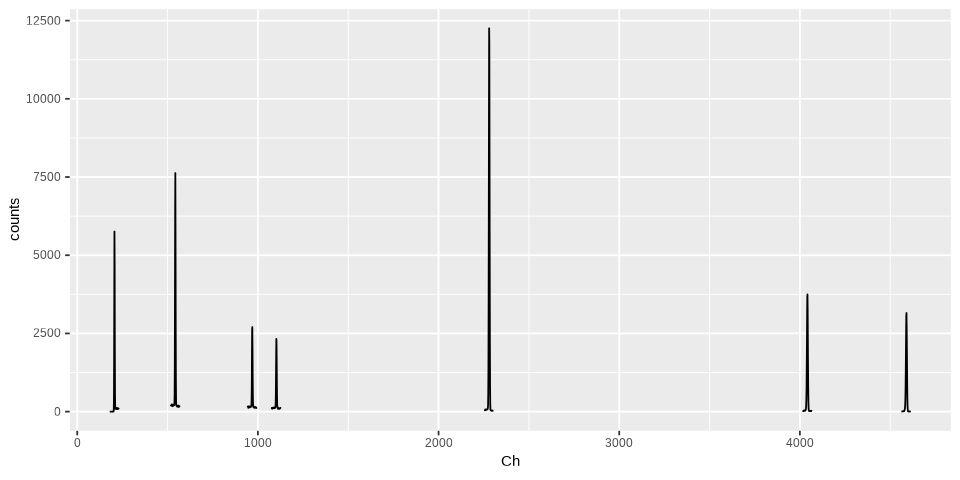

In [60]:
acc_plot <- plot_peaks(centered_peaks)
acc_plot

In [61]:
peaks <- convert_to_list(centered_peaks,5)
peaks[[1]]$x <- data_ACC$Ch[203:215]
peaks[[1]]$y <- data_ACC$counts[203:215]

In [62]:
peaks

[[1]]
[[1]]$x
 [1] 202 203 204 205 206 207 208 209 210 211 212 213 214

[[1]]$y
 [1]   48  328 1458 3690 5758 4707 2114  568  181   90   95   98   97


[[2]]
[[2]]$x
 [1] 535 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554
[20] 555 556 557 558 559 560 561 562 563 564 565 566 567

[[2]]$y
 [1]  227  205  256  547 1570 3904 6510 7626 5680 2856 1074  386  210  193  189
[16]  184  164  189  183  172  176  174  152  173  197  187  147  156  172  166
[31]  191  201


[[3]]
[[3]]$x
 [1] 961 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980
[20] 981 982 983 984 985 986 987 988 989 990 991 992 993

[[3]]$y
 [1]  161  166  182  350  788 1722 2593 2703 2070 1192  537  239  158  163  144
[16]  134  133  158  125  132  120  135  143  136  120  145  141  139  121  121
[31]  116  135


[[4]]
[[4]]$x
 [1] 1094 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
[16] 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124
[31] 1125 1126

[[4]]$y
 [1]  120  124  154  214  430  958 1712 2325 2215 1602  900  414  201  136  118
[16]  115  126   85  112   94  111   96   96  106   95   89   98  111  108  111
[31]  121  111


[[5]]
[[5]]$x
 [1] 2272 2274 2275 2276 2277 2278 2279 2280 2281 2282 2283 2284 2285 2286 2287
[16] 2288 2289 2290 2291 2292 2293 2294 2295 2296 2297 2298 2299 2300 2301 2302
[31] 2303 2304

[[5]]$y
 [1]    96   219   586  1400  3304  6290  9826 12254 11765  8721  5231  2355
[13]   899   272    70    48    43    41    31    36    25    36    36    31
[25]    40    31    28    27    27    30    28    28

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

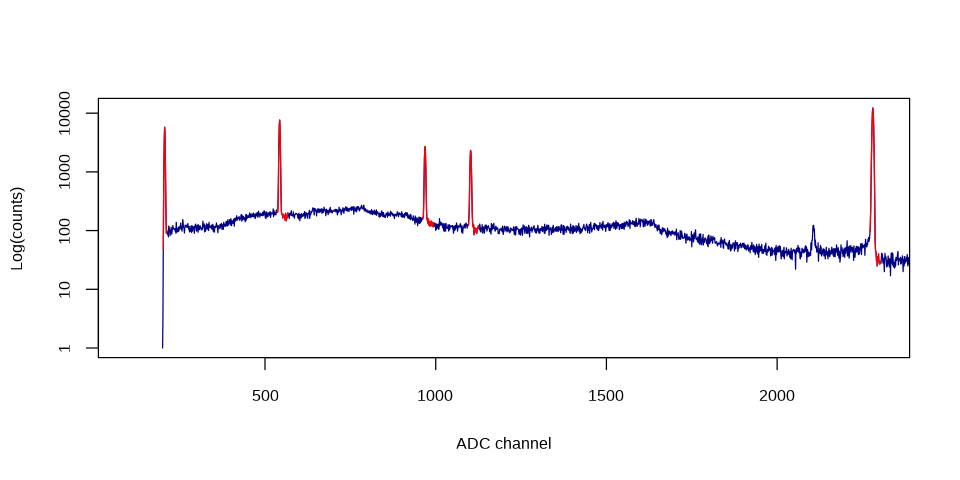

In [63]:
#Just to control we are picking the right ones
set_plot_dimensions(8,4)
plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    #xlim=c(150,3500),ylim=c(1.e-1,1.e5),
    xlim=c(100,2300),
    main = "",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:length(peaks)){lines(peaks[[i]]$x,peaks[[i]]$y,col="red")}
#lines(peaks[[1]]$x,peaks[[1]]$y,col="black")

## Peaks characterization

In [64]:
chain_data <- function(cadena){
 
    stat <- summary(cadena)$statistics
    qnt  <- summary(cadena)$quantiles
    mean  <- c(stat[1,1],stat[2,1],stat[3,1],stat[3,1])
    std    <- c(stat[1,2],stat[2,2],stat[3,2],stat[3,2])
    min_95 <- c(qnt[1,1],qnt[2,1],qnt[3,1],qnt[3,1])
    max_95 <- c(qnt[1,5],qnt[2,5],qnt[3,5],qnt[3,5])
    
    results <- data.frame(mean,std,min_95,max_95)
    row.names(results)<-c("A","B","w","x0")
    return(results)
}

In [65]:
#Using JAGS to estimate statistical properties of the peaks
peak_properties <- function (peaks, likelihood_str, priors_str){
    i=1
    chains <-c()
    x0_mean <-c()
    x0_std <-c()
    w_mean <-c()
    w_std <-c()


    for (pk in peaks){

        #Plot of the choosen peak
        set_plot_dimensions(4, 4)
        plot(pk$x,pk$y, type="l",
            pch = 1, cex=0.5, col="navy",
            ylab = "Log(counts)", xlab ="ADC channel",
            main=paste("peak",i))

        A.min <- min(pk$y)
        A.max <- max(pk$y)
        B.min <- 0
        B.max <- max(c(min(pk$y[1:floor(length(pk$y)/2)]),min(pk$y[floor(length(pk$y)/2):length(pk$y)])))  #This is a critical point for peaks that doesn't have a
                             #a stable noise around so min(pk$y) is not representative
        x0.min <- min(pk$x)  
        x0.max <- max(pk$x)

        cat("model{

            #The likelihood: 

",likelihood_str,"

            # Priors for  A, B, x0, w 

",priors_str(A.min,A.max, B.max, x0.min, x0.max),"
}", sep = '', file=paste("Models/model_peak_",i,".bug",sep=""))

        model <- paste("Models/model_peak_",i,".bug",sep="")


        #If multiple chains are run, each of them need to be initialized
        init <- NULL;init$A  <- (A.max-A.min)/2
        init$B  <- B.max;   init$w  <- 5; init$x0 <- (x0.max-x0.min)/2 + x0.min

        #To have absolute control we also set the seed for and random number generator for each chain
        init <- list(c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill"),
                     c(init,.RNG.seed  = 4021,.RNG.name = "base::Wichmann-Hill"),
                     c(init,.RNG.seed  = 1532,.RNG.name = "base::Wichmann-Hill"))


        chain_number <- 3
        burnin       <- 1000
        iterations   <- 1.e4
        thining      <- 10


        jm <- jags.model(model,
                         pk,
                         inits=init,
                         n.chains=chain_number,
                         quiet=TRUE)

        #Update the Markov chain (Burn-in)
        update(jm, burnin)

        chain <- coda.samples(jm, c("A","B","w","x0"), n.iter=iterations,thin=thining)
        chains <- append(chains,list(chain))
        #Generate the chain and posterior plots
        options(repr.plot.width = 10, repr.plot.height = 10)
        #plot(chain)
        print(paste("peak",i))
        print(chain_data(chain))

        A  <- summary(chain)$statistics[1]
        B  <- summary(chain)$statistics[2]
        w  <- summary(chain)$statistics[3]
        x0  <- summary(chain)$statistics[4]
        x0_mean <- c(x0_mean,x0)
        x0_std  <- c(x0_std,summary(chain)$statistics[4,2])
        w_mean <- c(w_mean,w)
        w_std  <- c(w_std,summary(chain)$statistics[3,2])

        x <- seq(x0.min,x0.max,0.25)
        f <-(A*exp((-(x-x0)^2)/(2*w^2))+B)


        set_plot_dimensions(4, 4)
        plot(pk$x,pk$y,
            ylab = "Counts", xlab ="ADC channel",
            main=paste("peak",i))
        lines(x,f, lwd=2, col='firebrick3')
        i=i+1
    }

    results <- NULL
    results$chains  <- chains
    results$x0_mean <- x0_mean
    results$x0_std  <- x0_std
    results$w_mean  <- w_mean
    results$w_std   <- w_std
        return(results)
}

[1] "peak 1"
          mean         std     min_95      max_95
A  5758.002286 0.137216363 5757.73411 5758.276714
B    89.978377 0.316393029   89.36205   90.625868
w     1.262844 0.006213732    1.25039    1.274975
x0    1.262844 0.006213732    1.25039    1.274975


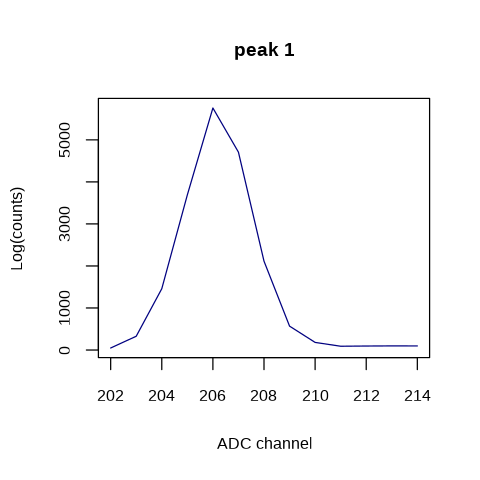

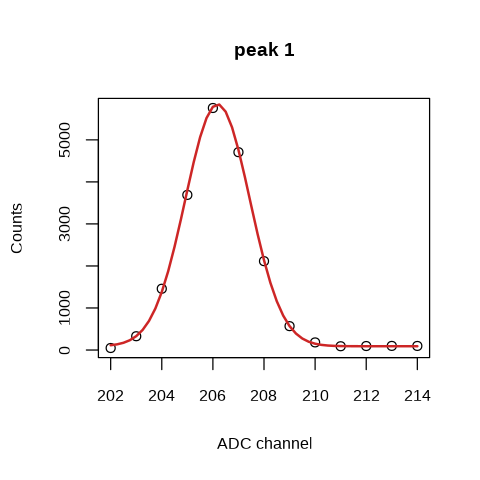

[1] "peak 2"
          mean         std      min_95      max_95
A  7626.001027 0.144979202 7625.715263 7626.288126
B   183.978536 0.311534853  183.359214  184.581917
w     1.526101 0.006098858    1.514219    1.537918
x0    1.526101 0.006098858    1.514219    1.537918


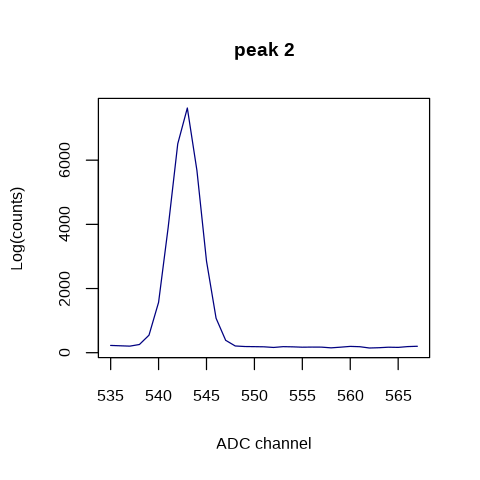

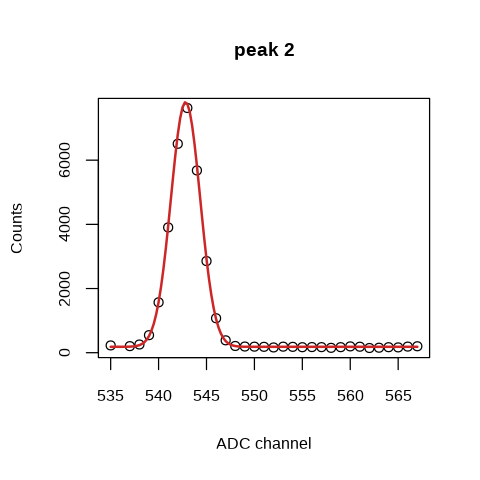

[1] "peak 3"
          mean        std      min_95      max_95
A  2702.998929 0.14117572 2702.718625 2703.275690
B   134.036905 0.30555426  133.455666  134.637025
w     1.656568 0.01159961    1.634298    1.679428
x0    1.656568 0.01159961    1.634298    1.679428


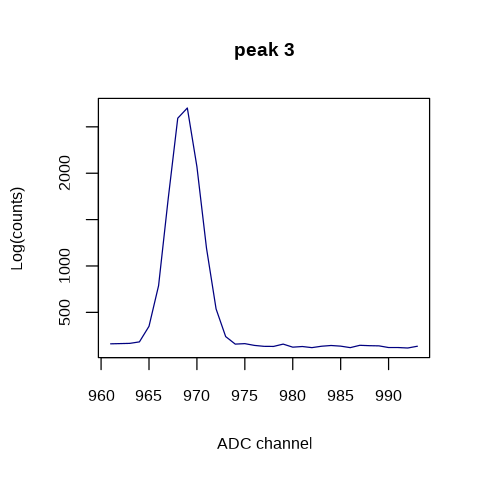

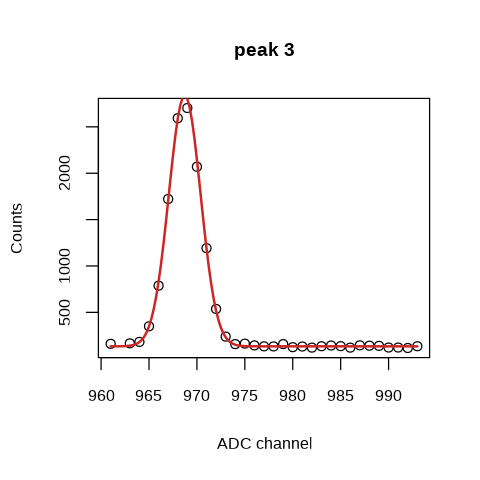

[1] "peak 4"
          mean        std      min_95      max_95
A  2324.993767 0.14154614 2324.721072 2325.278867
B   114.881976 0.31775888  114.261763  115.511957
w     1.734484 0.01285016    1.709529    1.759692
x0    1.734484 0.01285016    1.709529    1.759692


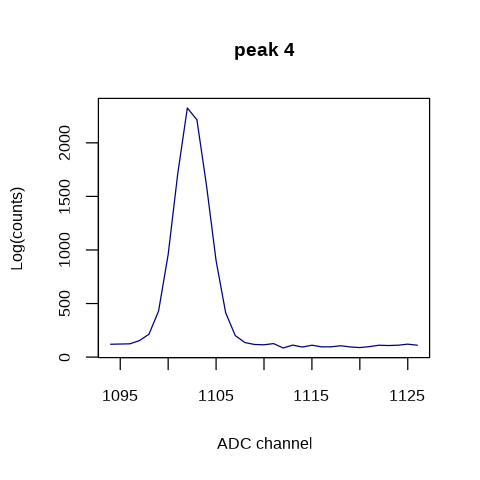

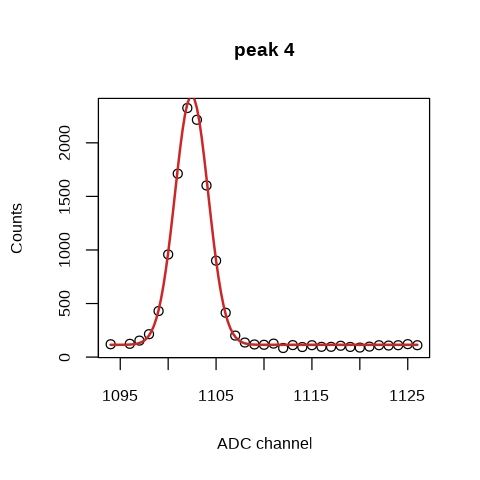

[1] "peak 5"
           mean         std       min_95       max_95
A  12254.000519 0.140618958 12253.729818 12254.275216
B     47.584116 0.305965078    47.013516    48.187636
w      2.043913 0.004995653     2.033862     2.053662
x0     2.043913 0.004995653     2.033862     2.053662


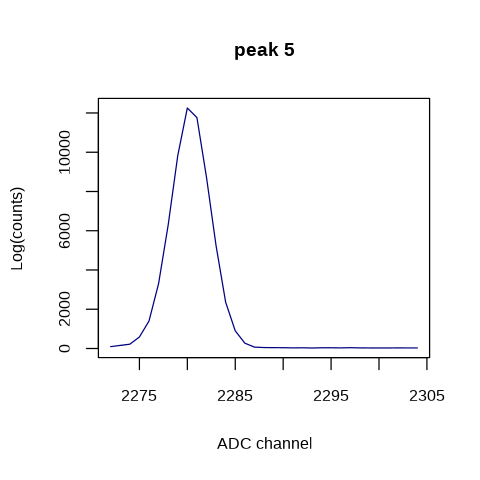

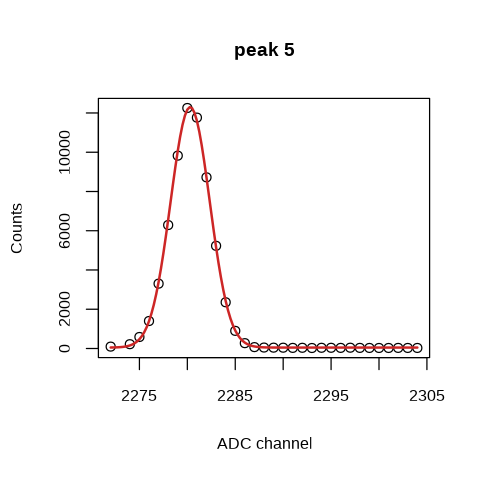

In [66]:
likelihood_str <- 'for (i in 1:length(x)){
S[i] <- (A * exp((-(x[i]-x0)^2) / ( 2 *w^2)) + B)
y[i] ~ dpois(S[i])
}'
priors_str <- function(A.min, A.max, B.max, x0.min, x0.max){
    priors_str <- paste("A ~ dnorm(",A.max,",",50,")
B ~ dnorm(",B.max,",",10,")
x0 ~ dunif(",x0.min,",",x0.max,")
w ~ dunif(1,10)", sep = '')
return(priors_str)
}

ACC_properties <- peak_properties(peaks, likelihood_str, priors_str)

#### Americum

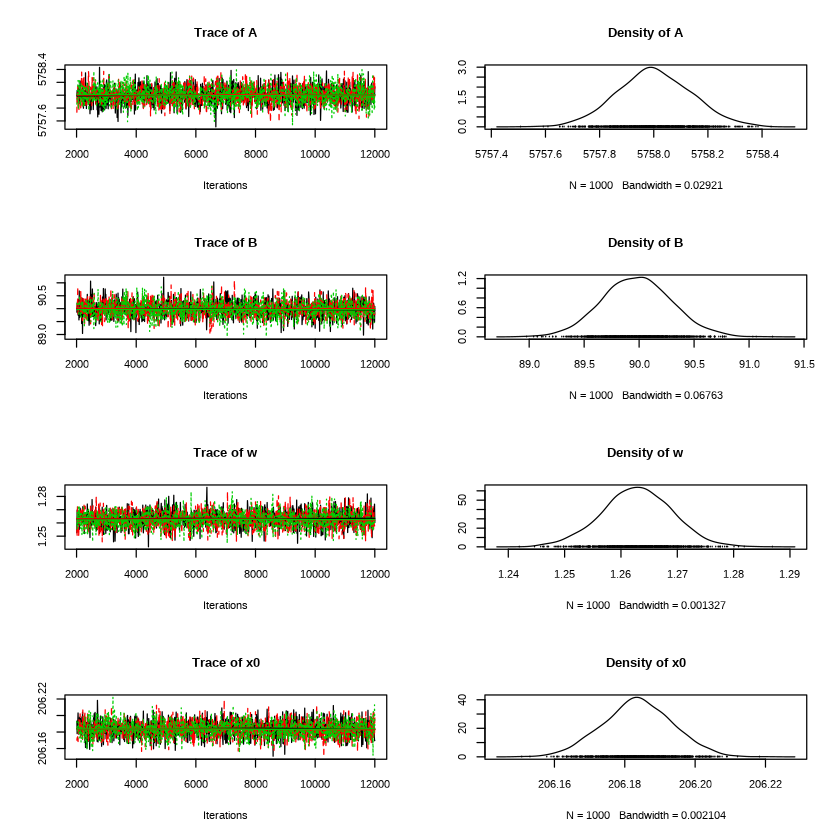

In [67]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[1]])

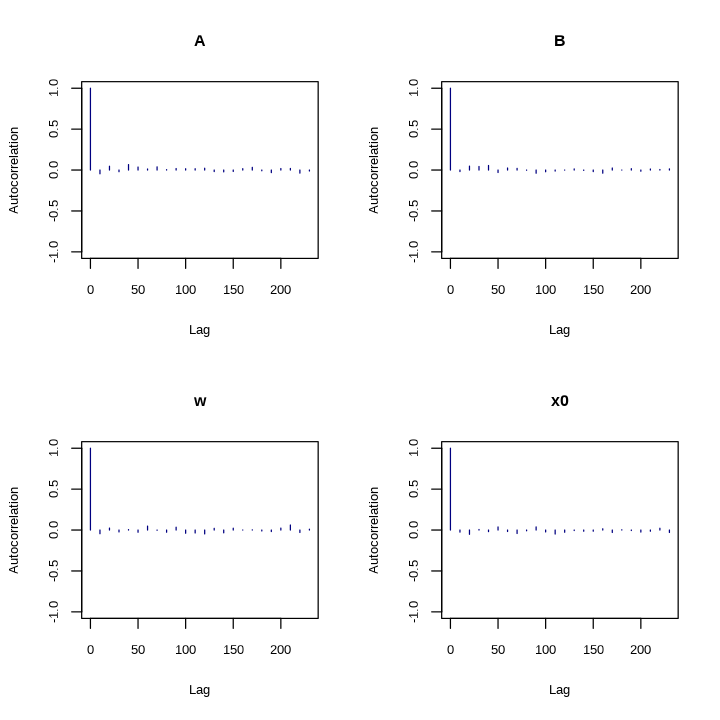

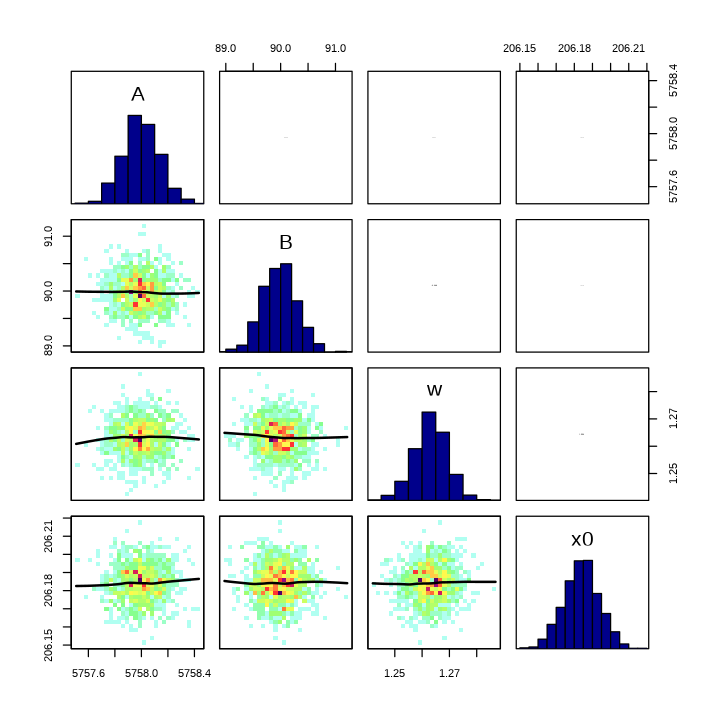

In [15]:
set_plot_dimensions(6, 6)

autocorr.plot(ACC_properties$chains[[1]][1], col='navy')
correlationPlot((ACC_properties$chains[[1]][1]))

#### Cs

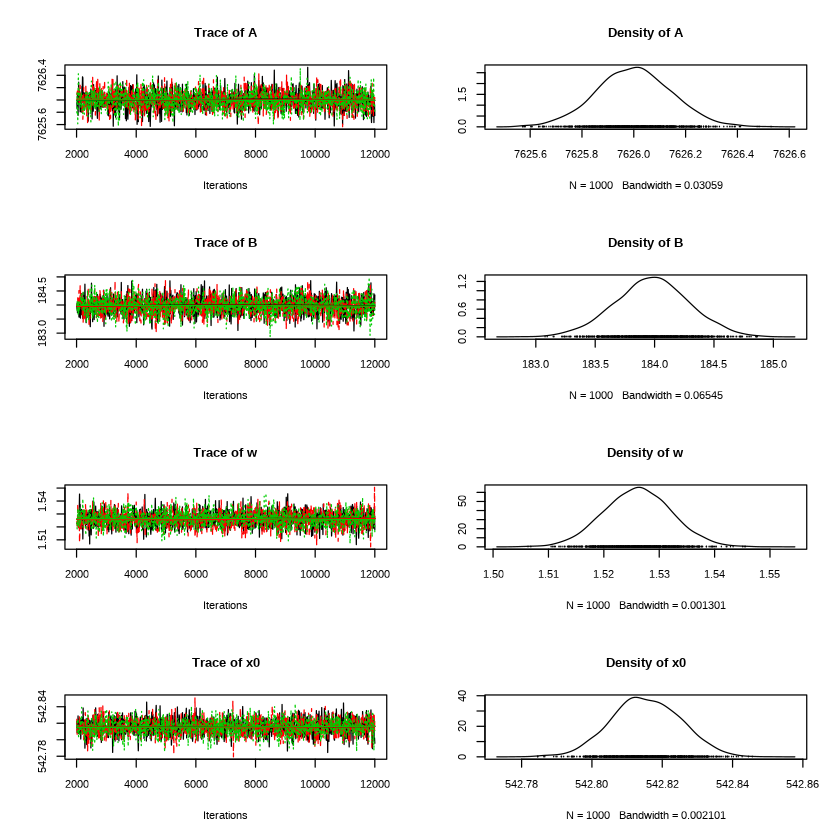

In [16]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[2]])

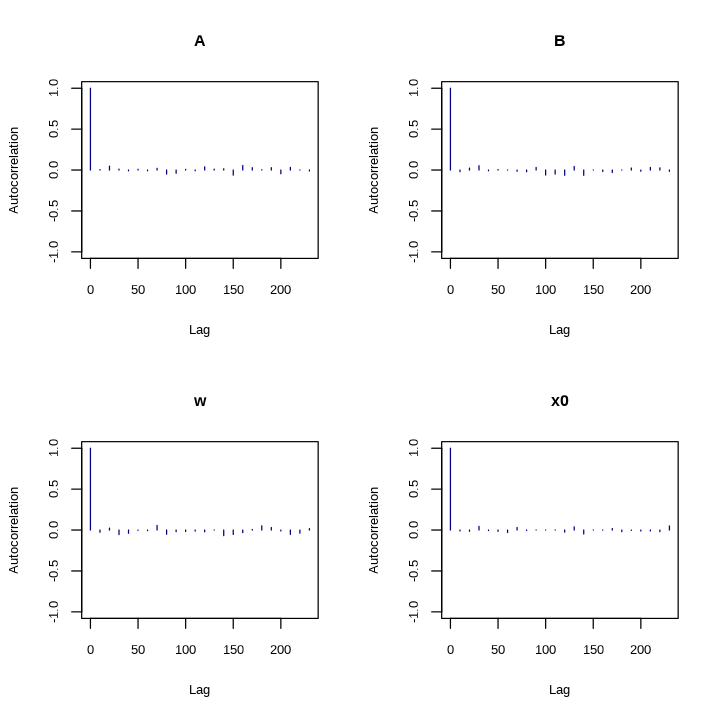

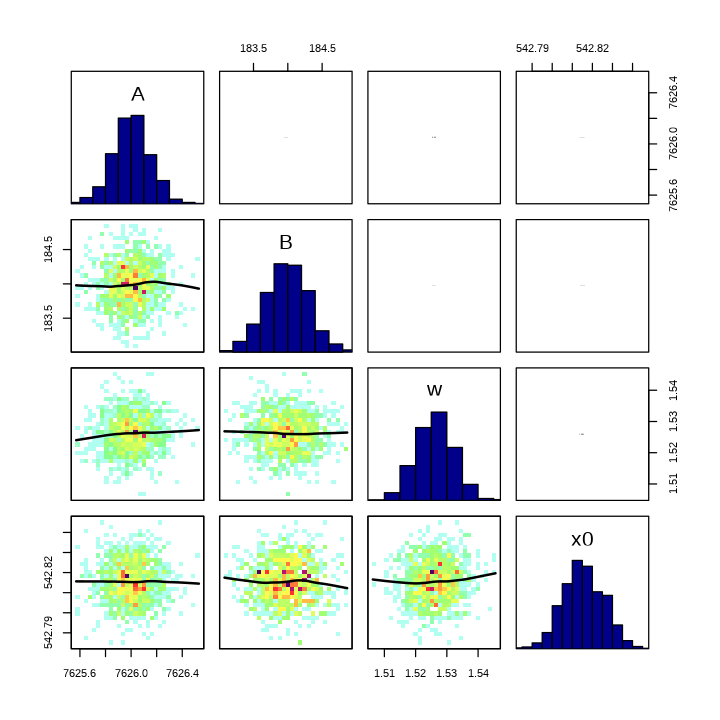

In [17]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[2]][1], col='navy')

correlationPlot((ACC_properties$chains[[2]][1]))

#### Co 1

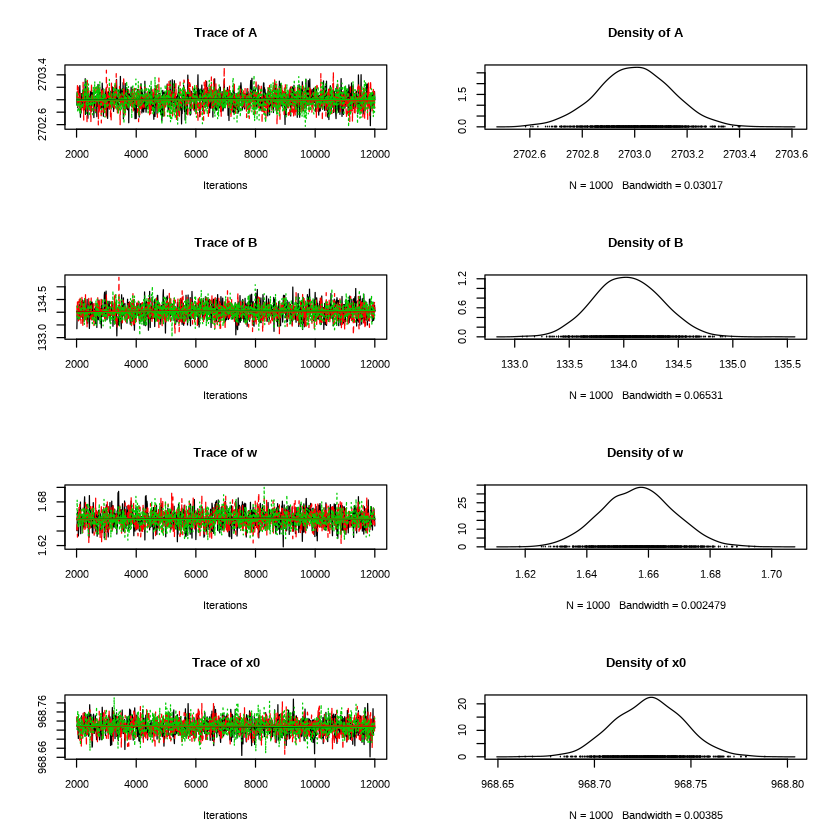

In [18]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[3]])

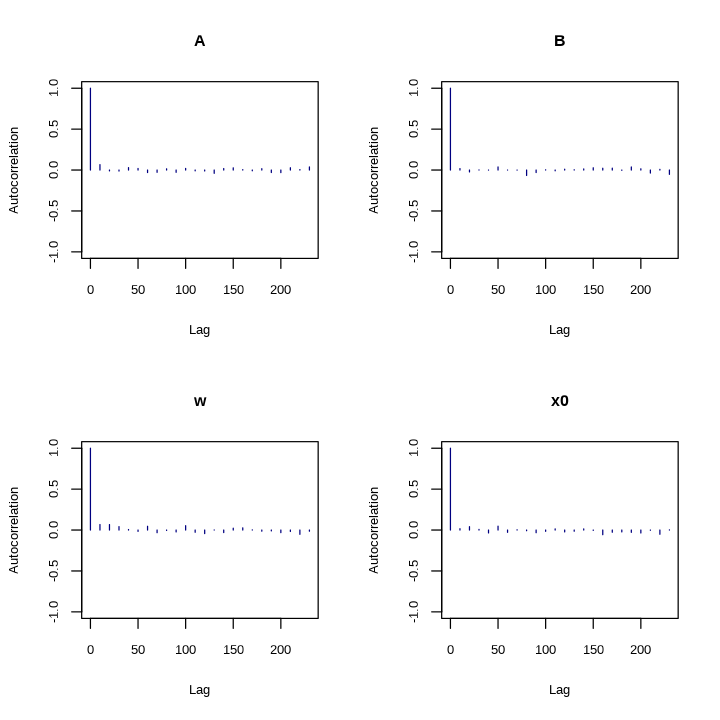

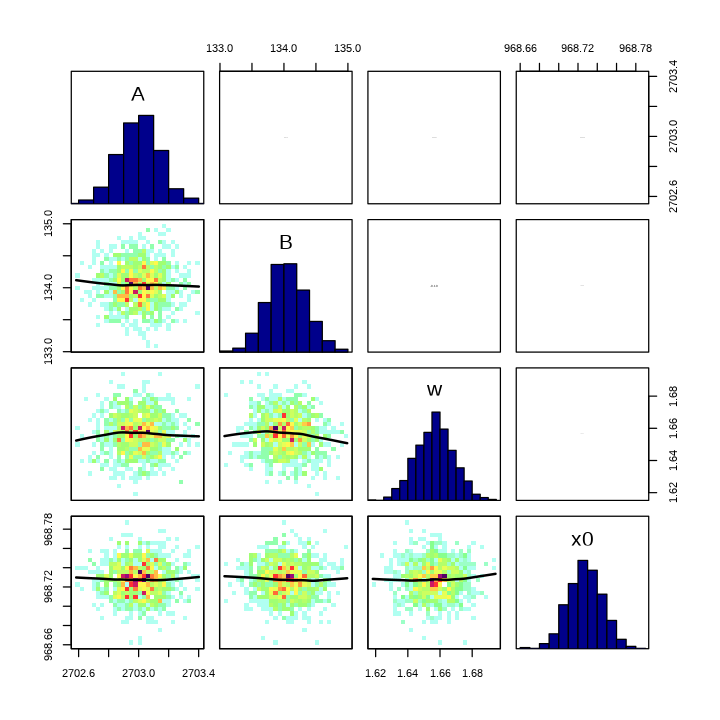

In [19]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[3]][1], col='navy')

correlationPlot((ACC_properties$chains[[3]][1]))

#### Co 2

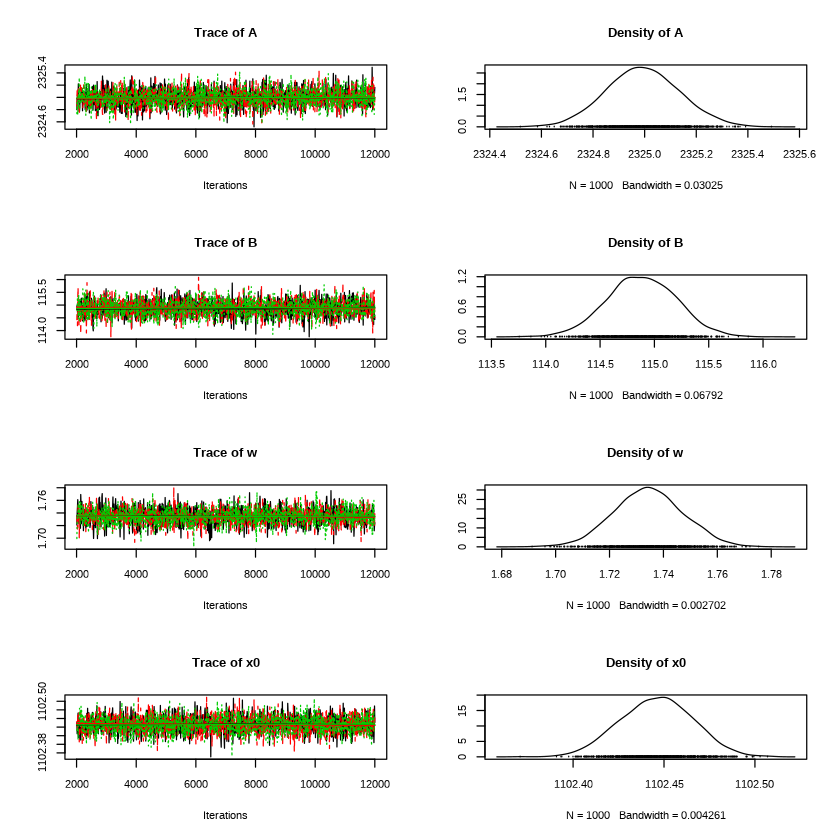

In [20]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[4]])

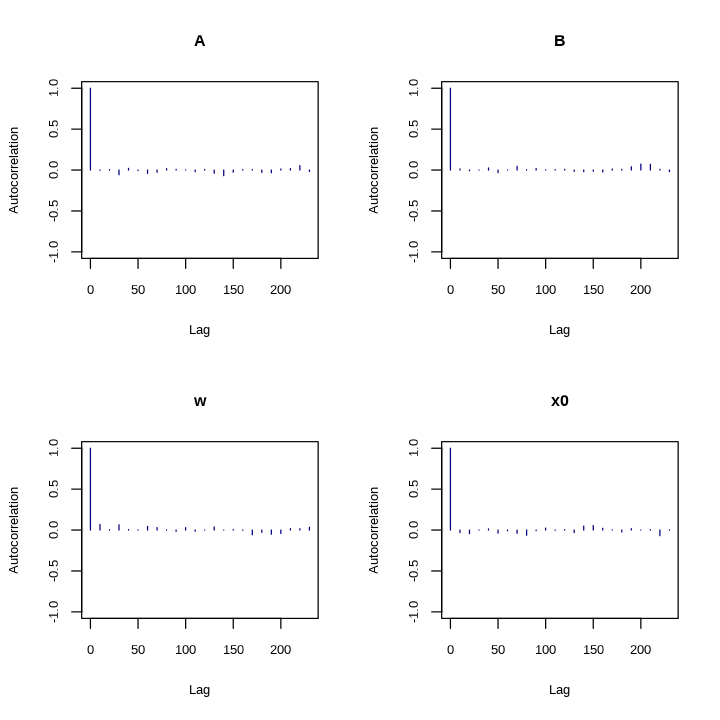

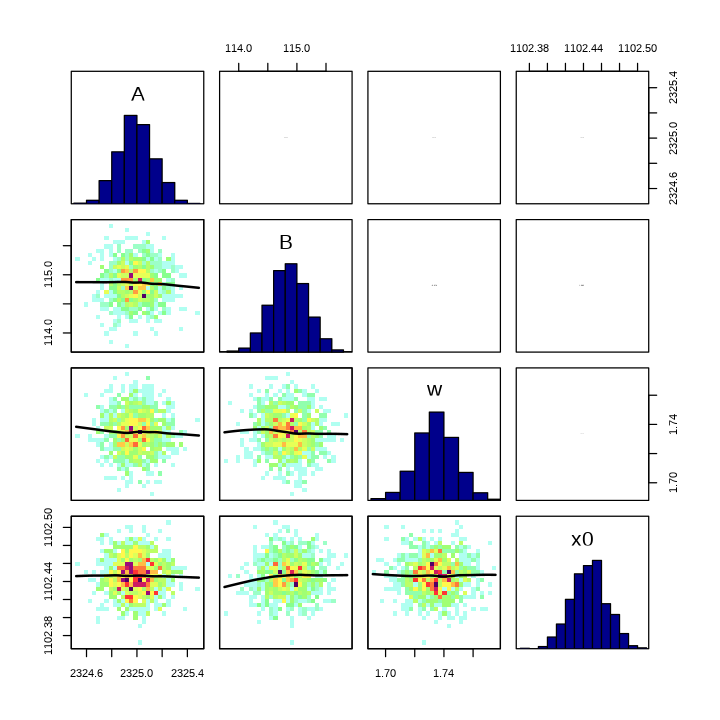

In [21]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[4]][1], col='navy')

correlationPlot((ACC_properties$chains[[4]][1]))

#### Co-3

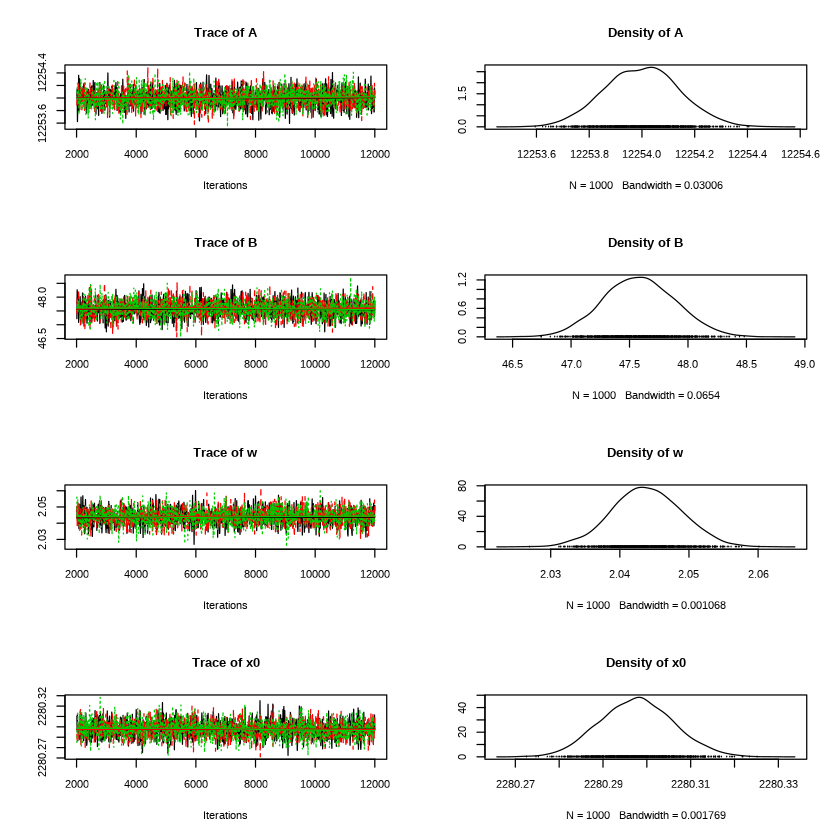

In [22]:
set_plot_dimensions(7, 7)
plot(ACC_properties$chains[[5]])

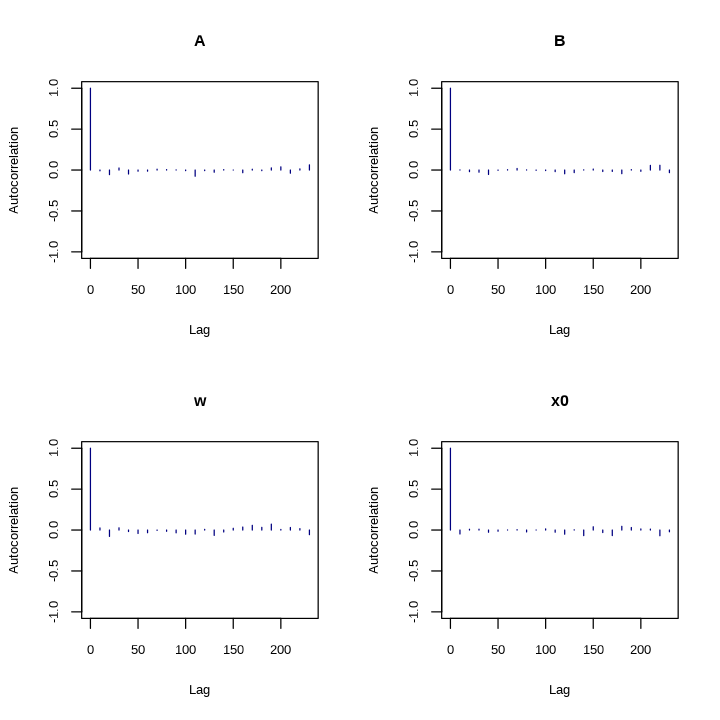

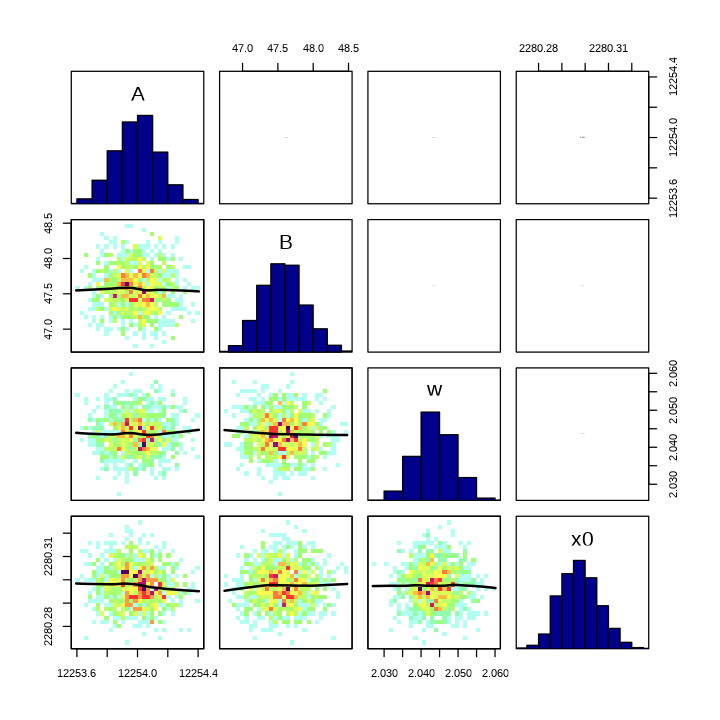

In [23]:
set_plot_dimensions(6, 6)
autocorr.plot(ACC_properties$chains[[5]][1], col='navy')

correlationPlot((ACC_properties$chains[[5]][1]))

## Energy calibration

In [24]:
df_ACC$x0_mean <- ACC_properties$x0_mean
df_ACC$x0_std  <- ACC_properties$x0_std
df_ACC$w_mean  <- ACC_properties$w_mean
df_ACC$w_std   <- ACC_properties$w_std

df_ACC

ACC_energies x0_mean   x0_std      w_mean   w_std      
Am     59.5409     206.1837 0.009927679 1.262844 0.006213732
Cs    661.6570     542.8154 0.009831598 1.526101 0.006098858
Co_1 1173.2280     968.7282 0.018010938 1.656568 0.011599613
Co_2 1332.4920    1102.4459 0.019934933 1.734484 0.012850163
Co_3 2505.6900    2280.2978 0.008278472 2.043913 0.004995653

In [25]:
linear_fit <- lm( df_ACC$ACC_energies[1:5] ~ df_ACC$x0_mean[1:5] )

intercept     <- summary(linear_fit)$coefficients[1,1]
std_intercept <- summary(linear_fit)$coefficients[1,2]
slope         <- summary(linear_fit)$coefficients[2,1]
std_slope     <-  summary(linear_fit)$coefficients[2,2
                                              ]
calibrated_energy <- function(x,a,b) a*x+b   #intercept + data_T$Ch*slope

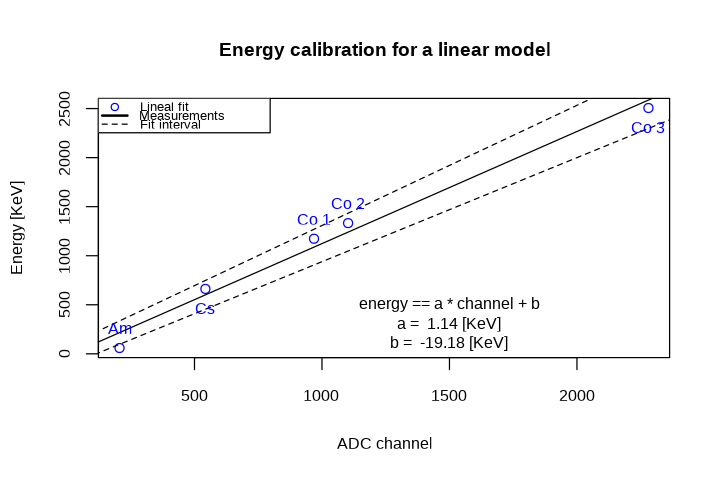

In [26]:
set_plot_dimensions(6, 4)
plot(df_ACC$x0_mean,df_ACC$ACC_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="Energy calibration for a linear model")
lines(data_ACC$Ch,calibrated_energy(data_ACC$Ch,slope,intercept))
lines(data_ACC$Ch,calibrated_energy(data_ACC$Ch,slope+std_slope,intercept+std_intercept),col="black",lty=2)
lines(data_ACC$Ch,calibrated_energy(data_ACC$Ch,slope-std_slope,intercept-std_intercept),col="black",lty=2)

legend("topleft", legend=c("Lineal fit", "Measurements","Fit interval"),
       col=c("blue","black","black"), lty=c(0,1,2),pch=c(1,-1,-1),lwd=c(1,2), cex=0.8)

text(df_ACC$x0_mean,df_ACC$ACC_energies+c(200,-200,200,200,-200),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(1500, 500, "energy == a * channel + b")
text(1500, 300, paste("a = ", sprintf("%.2f",slope),"[KeV]"))
text(1500, 100, paste("b = ", sprintf("%.2f",intercept),"[KeV]"))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1930 y values <= 0 omitted from logarithmic plot”

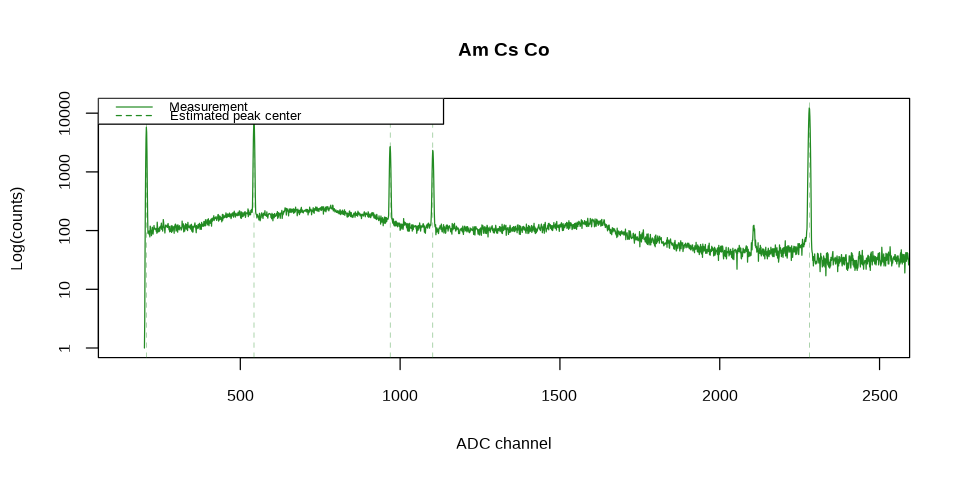

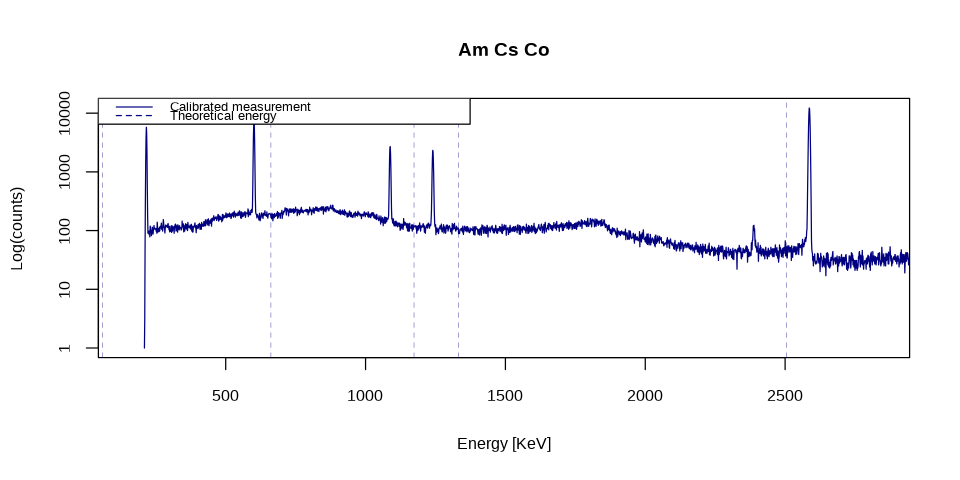

In [27]:
set_plot_dimensions(8, 4)

xmin <- 150;xmax<-2500
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_ACC$Ch,data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:5){ abline(v=ACC_properties$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)}
legend("topleft", legend=c("Measurement","Estimated peak center"),
       col=c("forestgreen"), lty=1:2, cex=0.8)


plot(calibrated_energy(data_ACC$Ch,slope,intercept),data_ACC$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in 1:5){
abline(v=df_ACC$ACC_energies[i],col="navy",lty=2,lwd=0.3)}
legend("topleft", legend=c("Calibrated measurement","Theoretical energy"),
       col=c("navy"), lty=1:2, cex=0.8)

## Resolution study

In [28]:
df_ACC$FWHM_mean <- 2*sqrt(2*log(2))*ACC_properties$w_mean
df_ACC$FWHM_std  <- 2*sqrt(2*log(2))*ACC_properties$w_std

In [29]:
df_ACC

ACC_energies x0_mean   x0_std      w_mean   w_std       FWHM_mean
Am     59.5409     206.1837 0.009927679 1.262844 0.006213732 2.973770 
Cs    661.6570     542.8154 0.009831598 1.526101 0.006098858 3.593692 
Co_1 1173.2280     968.7282 0.018010938 1.656568 0.011599613 3.900918 
Co_2 1332.4920    1102.4459 0.019934933 1.734484 0.012850163 4.084397 
Co_3 2505.6900    2280.2978 0.008278472 2.043913 0.004995653 4.813048 
     FWHM_std  
Am   0.01463222
Cs   0.01436171
Co_1 0.02731500
Co_2 0.03025982
Co_3 0.01176386

In [30]:
df_Resolution_ACC <- NULL
df_Resolution_ACC$x <- df_ACC$ACC_energies
df_Resolution_ACC$y <- df_ACC$FWHM_mean

In [31]:
chain_data_resolution <- function(cadena){
 
    stat <- summary(cadena)$statistics
    qnt  <- summary(cadena)$quantiles
    mean  <- c(stat[2,1],stat[3,1])
    std    <- c(stat[2,2],stat[3,2])
    min_95 <- c(qnt[2,1],qnt[3,1])
    max_95 <- c(qnt[2,5],qnt[3,5])
    
    results <- data.frame(mean,std,min_95,max_95)
    row.names(results)<-c("w","we")
    return(results)
}

In [32]:
resolution <- function(data){
   cat("model{

    #The likelihood:
    F = 0.113 #Fano factor
    
    for (i in 1:length(x)){
        f[i] <- sqrt(4*2*log(2) * F *x[i] * w + we**2);  
        
        y[i] ~ dnorm(f[i],sigma);
 
    } 


    # Priors for  

    w ~ dunif(1.e-3,1);
    we ~ dnorm(3,0.25);
    sigma ~ dnorm(0,1);
    #F ~dnorm(0.113,0.05)

      
    }", file="Models/ACC_resolution.bug")
    model <- "Models/ACC_resolution.bug" 
    
    init <- NULL
    init$w   <- 3.e-3
    init$we  <- 3;   init$sigma  <- 0.1;#   init$F  <- 0.113
    init <- c(init,.RNG.seed  = 3712,.RNG.name = "base::Wichmann-Hill")
    
    chain_number <- 10
    burnin       <- 1000
    iterations   <- 1.e4
    thining      <- 10
    
    jm <- jags.model(model,
                 data,
                 inits=init,
                 n.chains=chain_number,
                 quiet=TRUE)

    update(jm, burnin)
    
    
    
    chain <- coda.samples(jm, c("w","we","sigma"), n.iter=iterations,thin=thining)
    
    print(chain_data_resolution(chain))
    set_plot_dimensions(8,8)
    plot(chain)
    return(chain)
}

         mean         std       min_95    max_95
w  0.01126633 0.005511323  0.002023787 0.0233257
we 2.64871542 0.997321303 -0.029981417 3.9958598


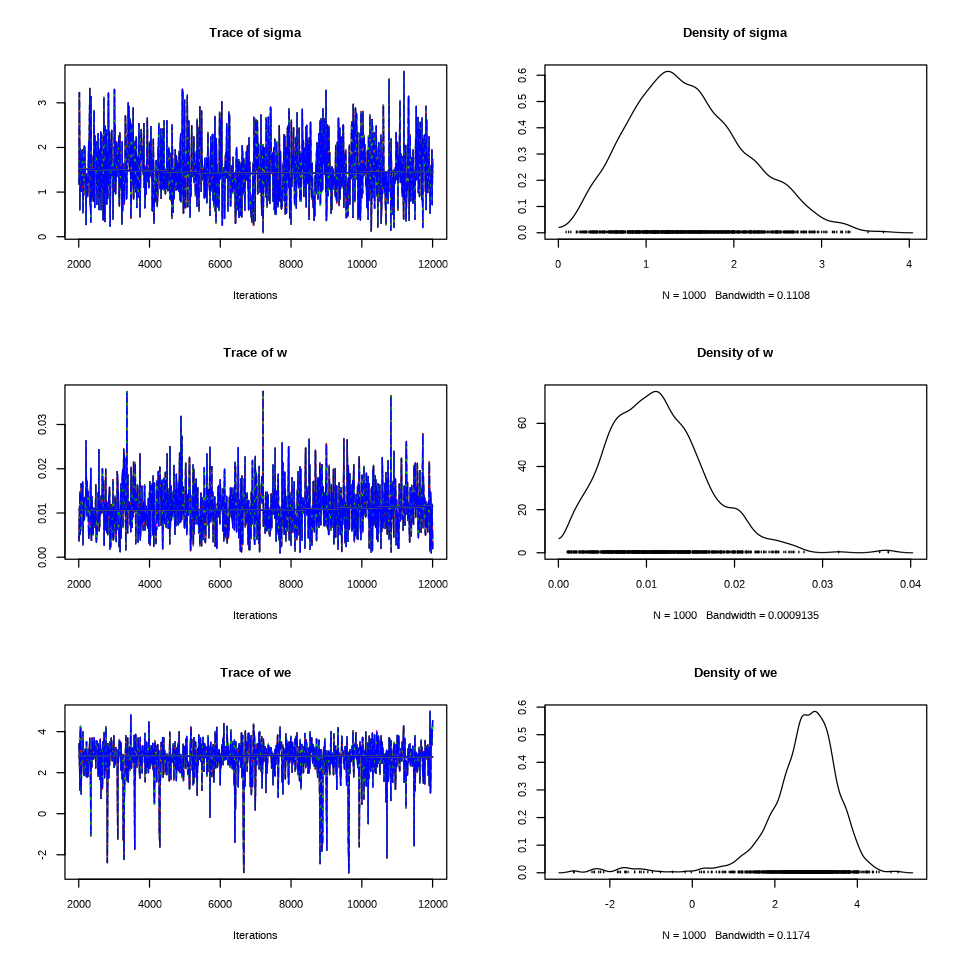

In [33]:
chain <- resolution(df_Resolution_ACC)

In [34]:
w      <- summary(chain)$statistics[2,1]; sw    <-  summary(chain)$statistics[2,2]
we     <- summary(chain)$statistics[3,1]; swe   <-  summary(chain)$statistics[3,2]
wmin   <- summary(chain)$quantiles[2,1];  wmax  <-  summary(chain)$quantiles[2,5]
wemin  <- summary(chain)$quantiles[3,1];  wemax <-  summary(chain)$quantiles[3,5]
w
we

[1] 0.01126633

[1] 2.648715

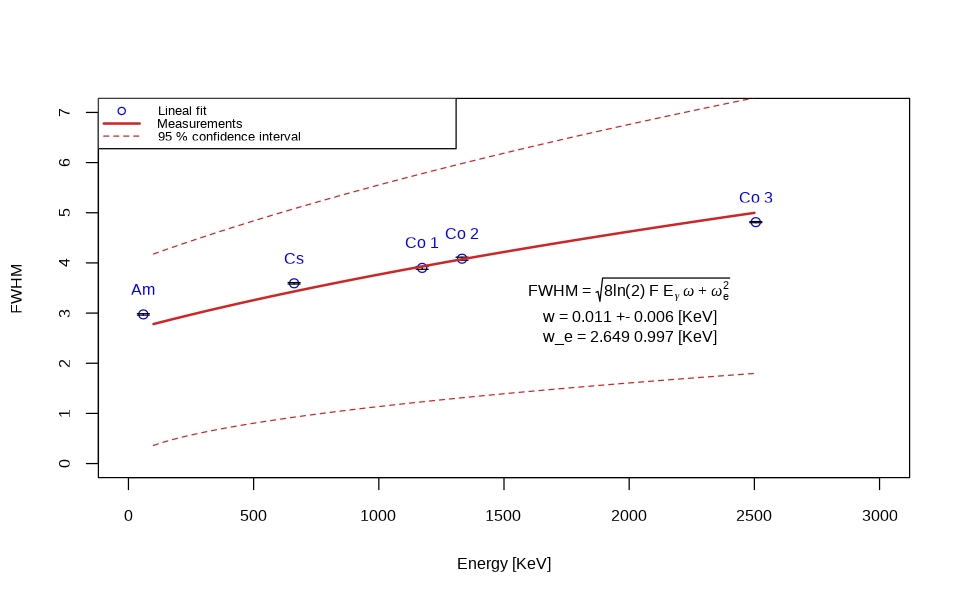

In [35]:
fano <-0.115
    
x <- seq(100,2500,1)
f <- function(x,w,we){return(sqrt(4*2*log(2) * fano * x * w + we**2))}
#f <- sqrt(0.007 * x  + 2.97**2)



set_plot_dimensions(8, 5)
plot(df_ACC$ACC_energies,df_ACC$FWHM_mean,col="blue",
    xlim=c(0,3000), ylim=c(0,7), 
    xlab="Energy [KeV]",ylab="FWHM",
    main="")

arrows(df_ACC$ACC_energies, df_ACC$FWHM_mean-df_ACC$FWHM_std,
       df_ACC$ACC_energies, df_ACC$FWHM_mean+df_ACC$FWHM_std,
       length=0.05, angle=90, code=3)
lines(x,f(x,w,we), lwd=2, col='firebrick3')
lines(x,f(x,wmin,wemin), lwd=1,lty=2, col='firebrick3')
lines(x,f(x,wmax,wemax), lwd=1,lty=2, col='firebrick3')

legend("topleft", legend=c("Lineal fit", "Measurements","95 % confidence interval"),
       col=c("blue","firebrick3","firebrick3"), lty=c(0,1,2),pch=c(1,-1,-1),lwd=c(1,2,1), cex=0.8)

text(df_ACC$ACC_energies,df_ACC$FWHM_mean+c(rep(0.5,5)),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(2000, 3.5,TeX("FWHM = $\\sqrt{8ln(2)\\,F\\,E_{\\gamma} \\,\\omega + \\omega_e^2}$"))
text(2000, 2.9, paste("w =", sprintf("%.3f",w),"+-",sprintf("%.3f",sw),"[KeV]"))
text(2000, 2.5, paste("w_e =", sprintf("%.3f",we),sprintf("%.3f",swe),"[KeV]"))

# Dataset 2

In [68]:
data_T <- read.table("data/IC48A_Th.txt", col.names = c('Ch', 'counts')) 

As we don't know which are the peaks to use we cheated, there is a paper from Baudis et.al https://arxiv.org/pdf/1508.05731.pdf with the spectrum from Th in a Germanium detector and there the peaks are identified so we picked two of them which were clearly the same as in our spectrum and used them to "calibrate the energy". We used this information to identify the peaks in our spectrum.

The 511 energy peak is between the channels 3150,3250 centered at 3215

The 2614 energy peak is between the channels 16200,16600 centered at 16450

As the lines we plotted clearly fit existing peaks, we trust that we are picking the correct ones. 

## Visualization

In [69]:
T_energies <-c(238.632,300.089,510.74,583.187,727.330,763.45,785.37,860.53,893.408,1078.63,1512.70,1592.511,1620.738,2103.511,2614.511)
df_T <- data.frame(T_energies)
row.names(df_T)<-c("Th 1","Th 2","Th 3","Th 4","Th 5","Th 6","Th 7", "Th 8", "Th 9", "Th 10", "Th 11", "Th 12", "Th 13", "Th 14", "Th 15")
df_T

T_energies
Th 1   238.632  
Th 2   300.089  
Th 3   510.740  
Th 4   583.187  
Th 5   727.330  
Th 6   763.450  
Th 7   785.370  
Th 8   860.530  
Th 9   893.408  
Th 10 1078.630  
Th 11 1512.700  
Th 12 1592.511  
Th 13 1620.738  
Th 14 2103.511  
Th 15 2614.511

In [70]:
ch1<-3215;en1<-511
ch2<-16450;en2<-2614
b<-(ch1-ch2)/(en1-en2)
a<-ch1-en1*b
ch_th <- a+ df_T$T_energies *b

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

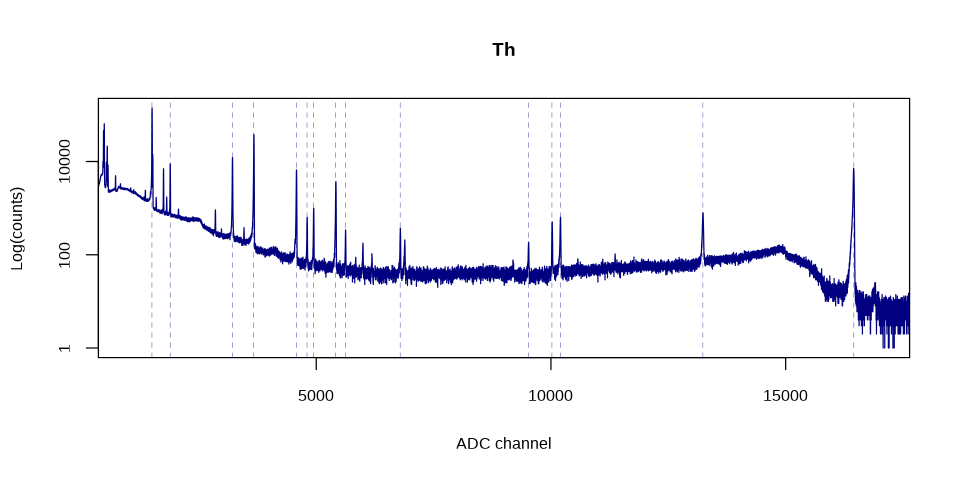

In [71]:
set_plot_dimensions(8, 4)

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){ abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)}

## Peak detection and characterization 

In [72]:
 th_1 <- NULL; th_1$x <- data_T$Ch[1450:1550]; th_1$y <- data_T$counts[1450:1550]

 th_2 <- NULL; th_2$x <- data_T$Ch[1850:1950]; th_2$y <- data_T$counts[1850:1950]

 th_3 <- NULL;  th_3$x <- data_T$Ch[3100:3300]; th_3$y <- data_T$counts[3100:3300]

 th_4 <- NULL; th_4$x <- data_T$Ch[3600:3750]; th_4$y <- data_T$counts[3600:3750]

 th_5 <- NULL; th_5$x <- data_T$Ch[4500:4650]; th_5$y <- data_T$counts[4500:4650]

 th_6 <- NULL; th_6$x <- data_T$Ch[4750:4850]; th_6$y <- data_T$counts[4750:4850]

 th_7 <- NULL; th_7$x <- data_T$Ch[4900:5000]; th_7$y <- data_T$counts[4900:5000]

 th_8 <- NULL; th_8$x <- data_T$Ch[5350:5475]; th_8$y <- data_T$counts[5350:5475]

 th_9 <- NULL; th_9$x <- data_T$Ch[5600:5650]; th_9$y <- data_T$counts[5600:5650]

 th_10 <- NULL; th_10$x <- data_T$Ch[6750:6850]; th_10$y <- data_T$counts[6750:6850]

 th_11 <- NULL; th_11$x <- data_T$Ch[9500:9550]; th_11$y <- data_T$counts[9500:9550]

 th_12 <- NULL; th_12$x <- data_T$Ch[10000:10060]; th_12$y <- data_T$counts[10000:10060]

 th_13 <- NULL; th_13$x <- data_T$Ch[10150:10250]; th_13$y <- data_T$counts[10150:10250]

 th_14 <- NULL; th_14$x <- data_T$Ch[13150:13300]; th_14$y <- data_T$counts[13150:13300]

 th_15 <- NULL; th_15$x <- data_T$Ch[16200:16600]; th_15$y <- data_T$counts[16200:16600]


 th_peaks <-list(th_1,th_2,th_3,th_4,th_5,th_6,th_7,th_8,th_9,th_10,th_11,th_12,th_13,th_14,th_15)

In [73]:
#We must re think how to implement this

#T_peaks <- probe_peaks(data_T, 60, 8000)
#th_peaks <- convert_to_list(T_peaks,10)

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

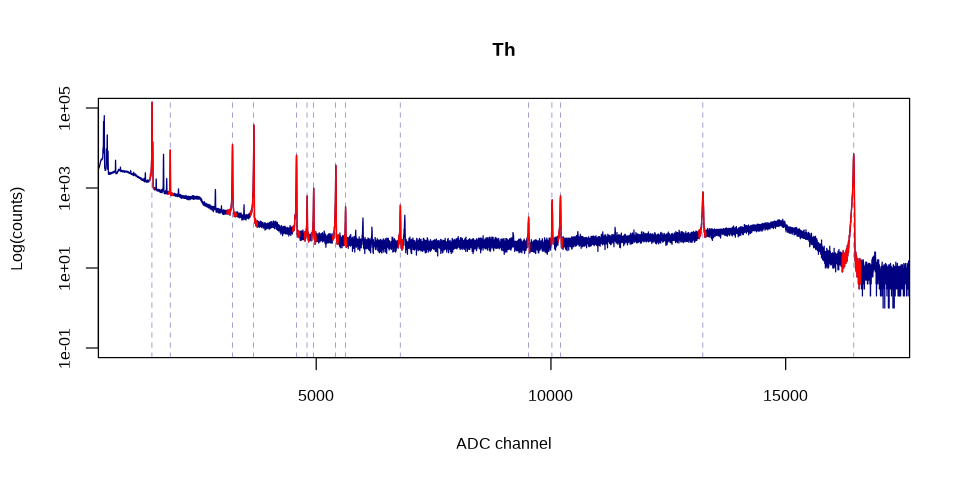

In [74]:
#Just to control we are picking the right ones
plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(1000,17000),ylim=c(1.e-1,1.e5),
    #xlim=c(16000,17000),
    main = "Th",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){abline(v=ch_th[i],col="navy",lty=2,lwd=0.3)}
for (i in 1:length(th_peaks)){lines(th_peaks[[i]]$x,th_peaks[[i]]$y,col="red")}

## Peaks characterization

[1] "peak 1"
           mean         std       min_95       max_95
A  1.403171e+05 0.141032783 1.403168e+05 1.403174e+05
B  1.531106e+03 0.312264748 1.530473e+03 1.531711e+03
w  2.371527e+00 0.002372202 2.366865e+00 2.376155e+00
x0 2.371527e+00 0.002372202 2.366865e+00 2.376155e+00


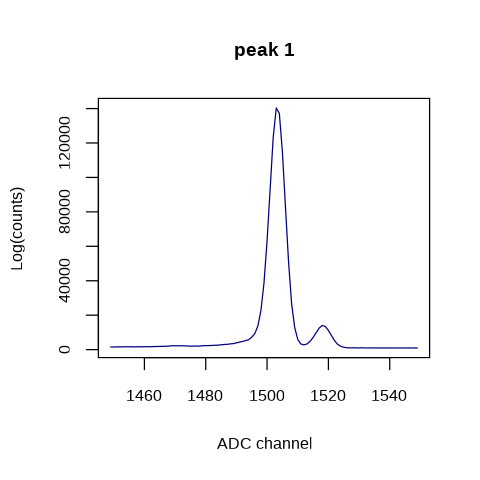

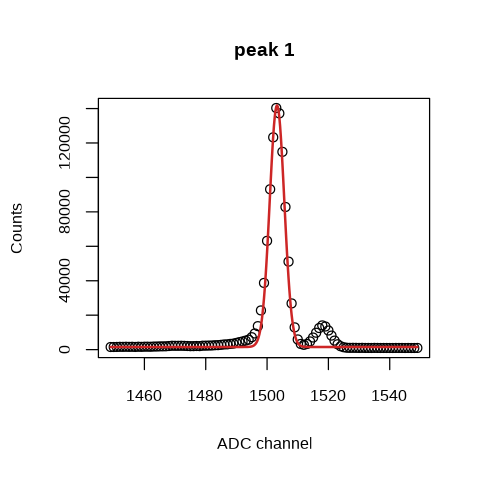

[1] "peak 2"
          mean        std      min_95      max_95
A  8898.055082 0.13942176 8897.779063 8898.328318
B   699.002540 0.31855395  698.358477  699.637429
w     1.981655 0.01189129    1.958792    2.005151
x0    1.981655 0.01189129    1.958792    2.005151


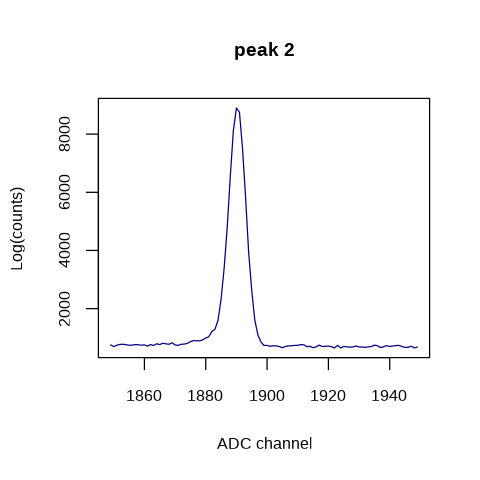

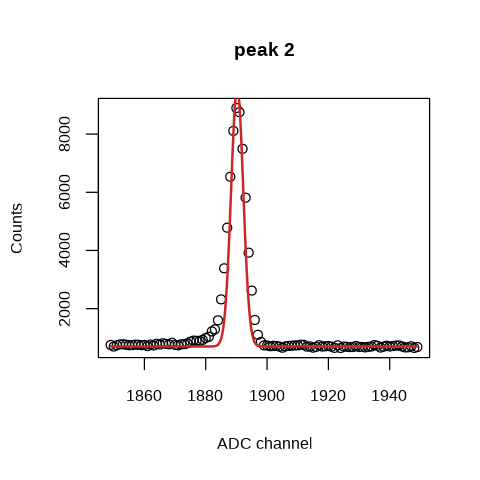

[1] "peak 3"
           mean        std       min_95       max_95
A  12095.121069 0.13856070 12094.852635 12095.391695
B    226.970075 0.30377365   226.367594   227.580517
w      3.108438 0.01058672     3.087204     3.128685
x0     3.108438 0.01058672     3.087204     3.128685


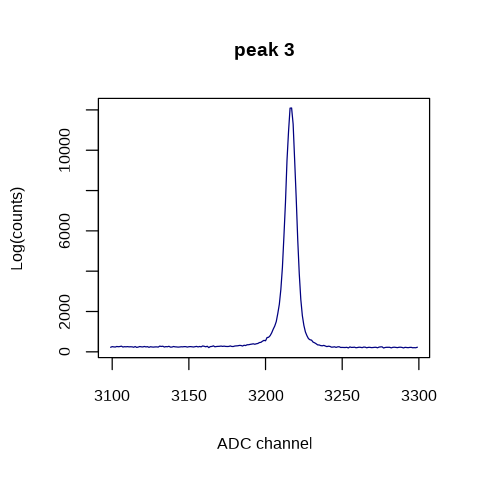

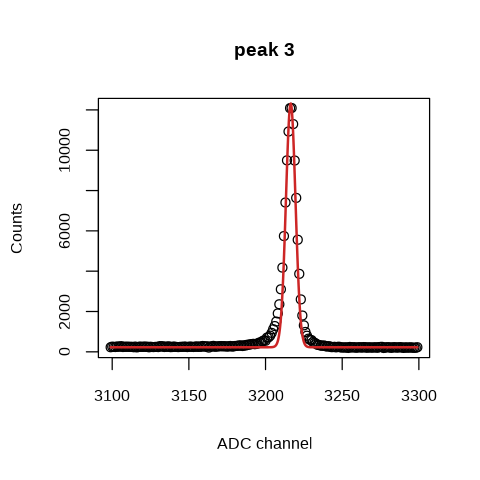

[1] "peak 4"
           mean         std       min_95       max_95
A  37495.147194 0.141270044 37494.870189 37495.421225
B    222.559637 0.301606023   221.986316   223.152401
w      3.436646 0.005715286     3.425146     3.447776
x0     3.436646 0.005715286     3.425146     3.447776


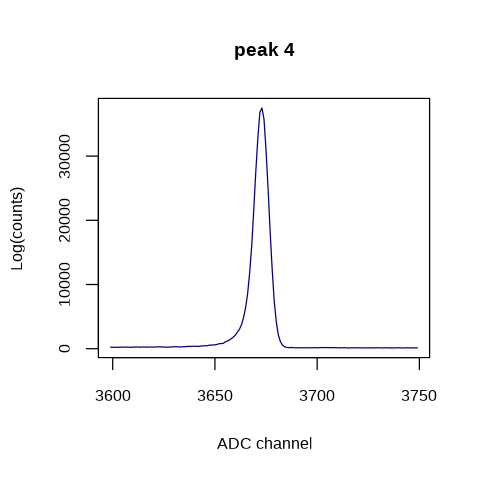

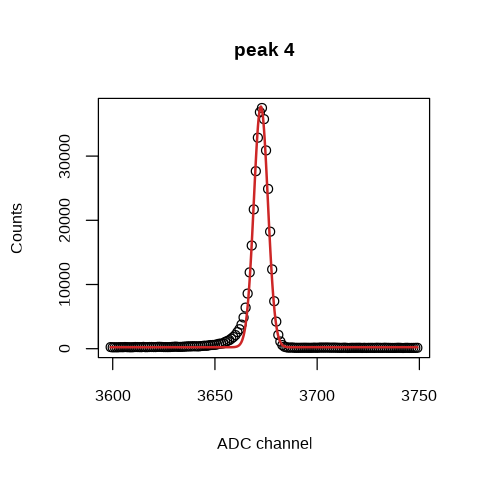

[1] "peak 5"
          mean        std      min_95      max_95
A  6587.138950 0.14124079 6586.860658 6587.412016
B    98.362691 0.28587733   97.807116   98.943597
w     3.414778 0.01447602    3.387982    3.443149
x0    3.414778 0.01447602    3.387982    3.443149


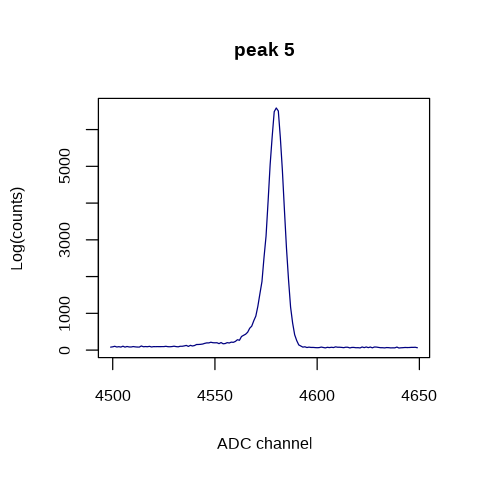

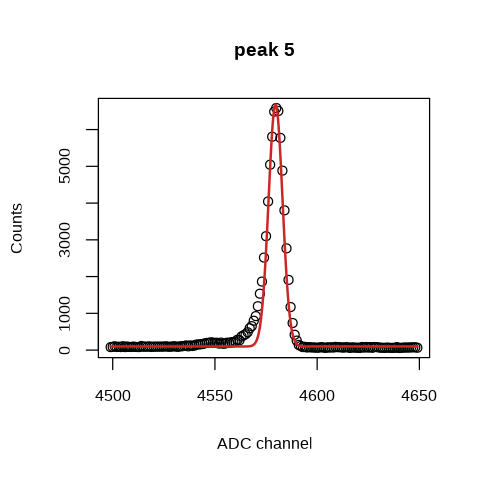

[1] "peak 6"
         mean        std     min_95     max_95
A  630.068524 0.13711971 629.798125 630.335734
B   54.981946 0.27691991  54.439202  55.519964
w    2.664065 0.06138574   2.545547   2.786089
x0   2.664065 0.06138574   2.545547   2.786089


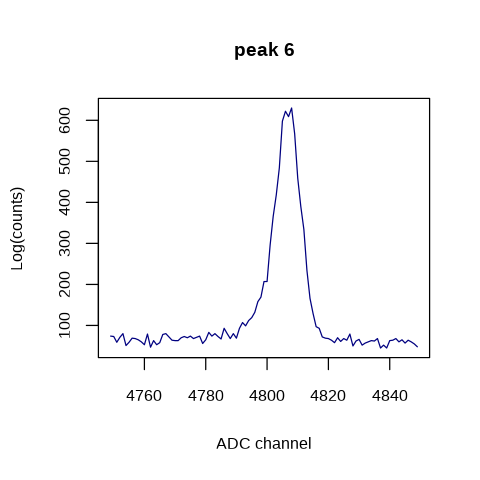

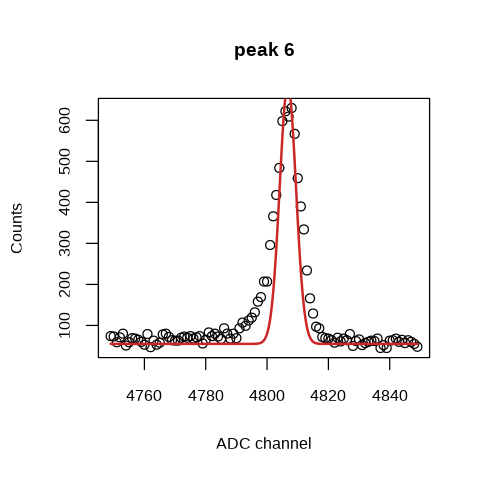

[1] "peak 7"
         mean        std     min_95     max_95
A  990.093021 0.14043089 989.810408 990.366917
B   57.610585 0.27758332  57.065767  58.143166
w    2.863391 0.04477906   2.776112   2.951101
x0   2.863391 0.04477906   2.776112   2.951101


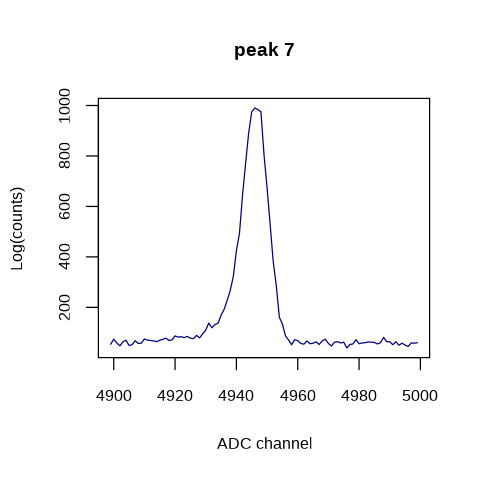

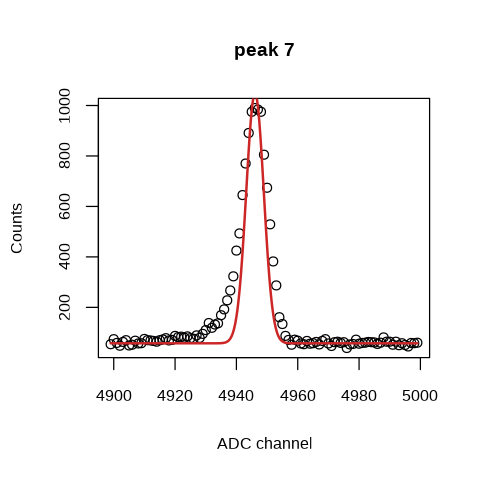

[1] "peak 8"
          mean        std      min_95     max_95
A  3694.138943 0.14088065 3693.856483 3694.41331
B    66.980954 0.28003290   66.416888   67.52390
w     3.568625 0.02035678    3.528452    3.60747
x0    3.568625 0.02035678    3.528452    3.60747


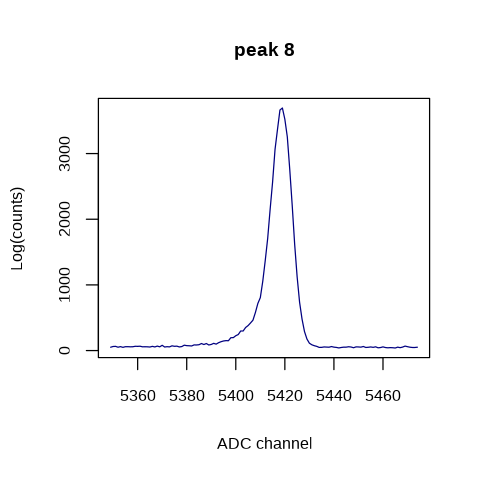

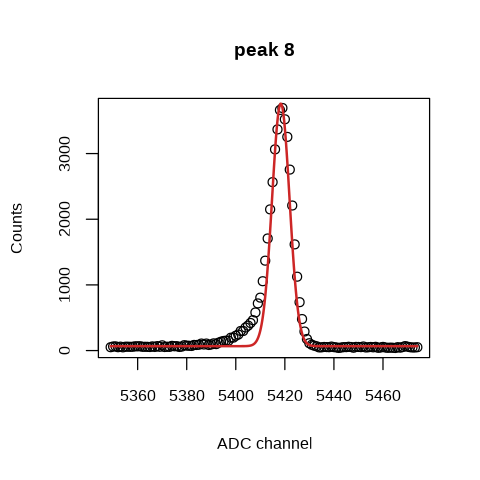

[1] "peak 9"
         mean        std     min_95     max_95
A  340.050605 0.14191319 339.772791 340.325498
B   42.271647 0.28874049  41.713492  42.842851
w    2.595883 0.09801875   2.406262   2.792245
x0   2.595883 0.09801875   2.406262   2.792245


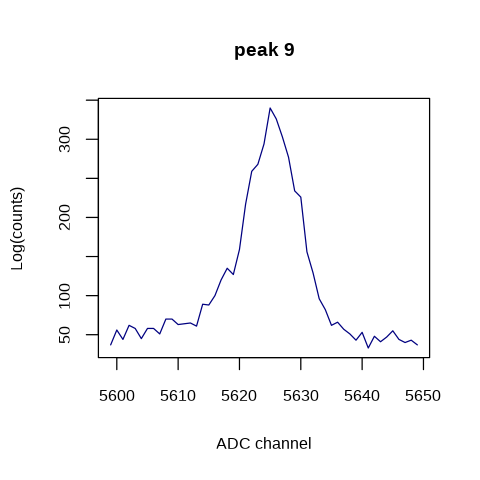

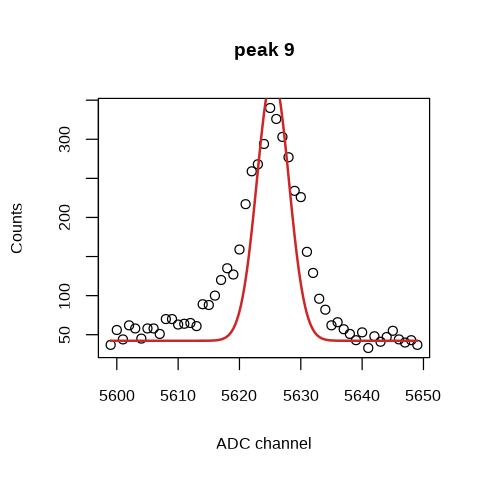

[1] "peak 10"
         mean        std     min_95     max_95
A  369.065614 0.14280861 368.791919 369.344500
B   39.978703 0.27278763  39.422331  40.502356
w    2.801593 0.09376137   2.618844   2.989656
x0   2.801593 0.09376137   2.618844   2.989656


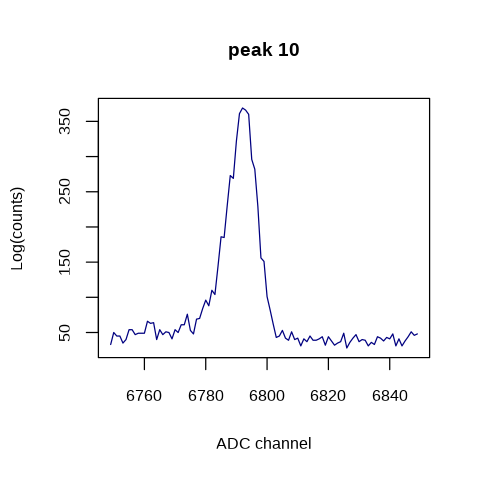

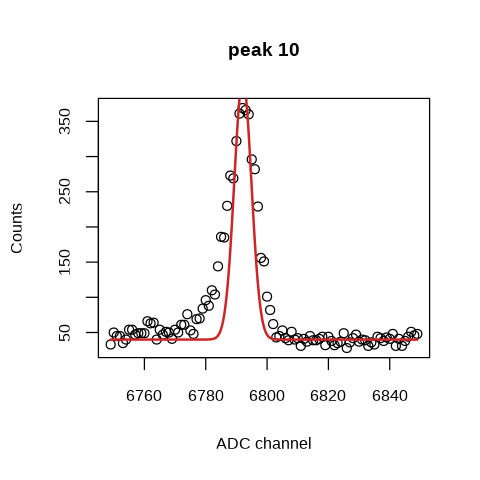

[1] "peak 11"
         mean       std     min_95     max_95
A  186.036397 0.1412850 185.758728 186.313941
B   38.329223 0.2877408  37.764940  38.892921
w    2.863034 0.1932915   2.493778   3.246919
x0   2.863034 0.1932915   2.493778   3.246919


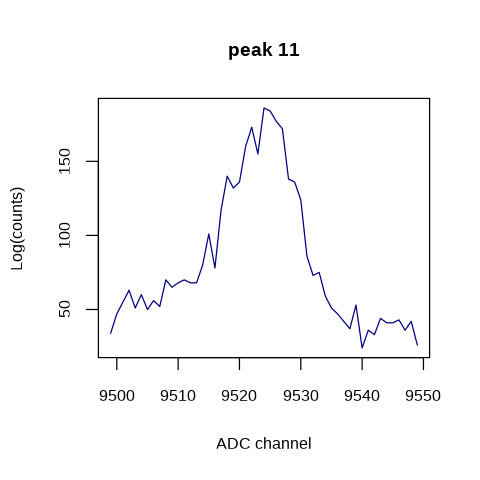

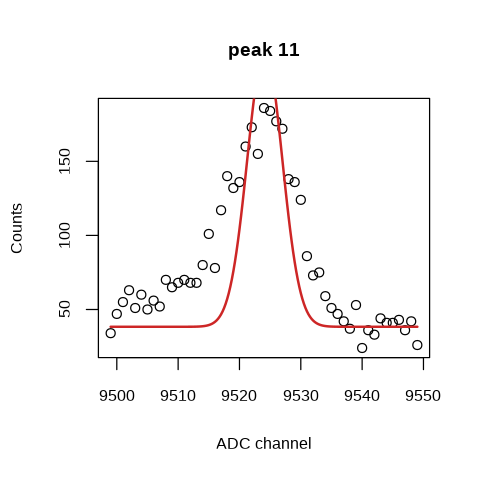

[1] "peak 12"
         mean        std     min_95     max_95
A  506.077366 0.14282434 505.797925 506.347627
B   47.432100 0.28668244  46.883671  48.016442
w    3.103438 0.08096814   2.945417   3.263287
x0   3.103438 0.08096814   2.945417   3.263287


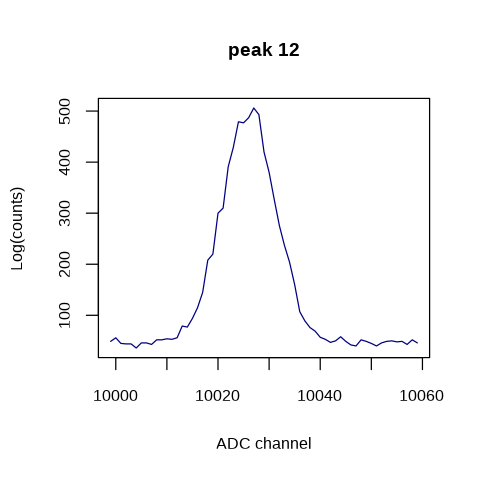

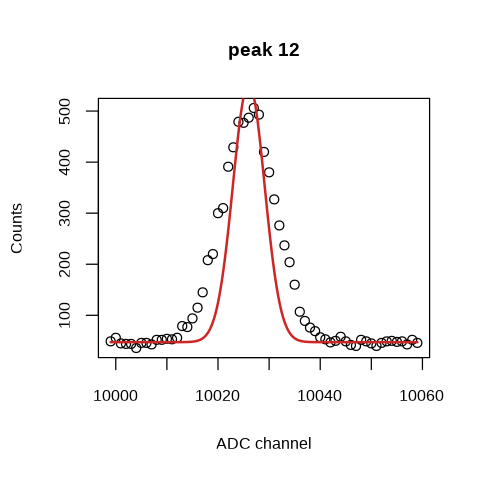

[1] "peak 13"
         mean        std     min_95     max_95
A  639.081250 0.14007892 638.808462 639.363756
B   54.082464 0.28041023  53.530159  54.629044
w    3.455408 0.07497882   3.306869   3.600515
x0   3.455408 0.07497882   3.306869   3.600515


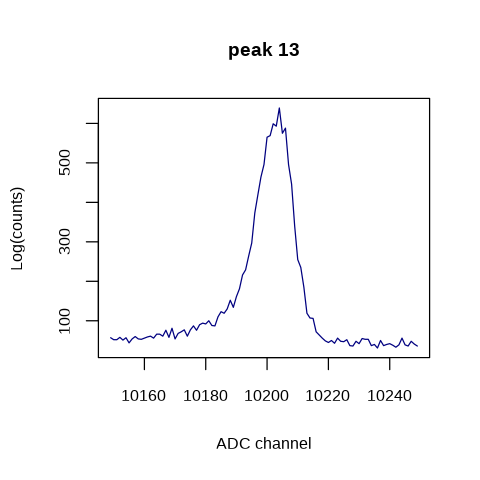

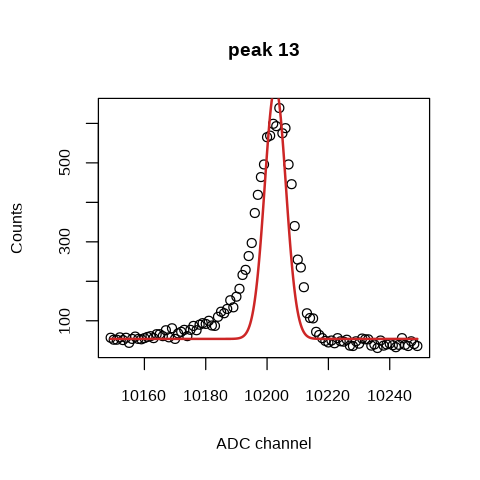

[1] "peak 14"
         mean       std    min_95     max_95
A  797.092399 0.1403084 796.81180 797.374403
B   74.802472 0.2701375  74.27773  75.317742
w    4.592482 0.1013793   4.39677   4.794838
x0   4.592482 0.1013793   4.39677   4.794838


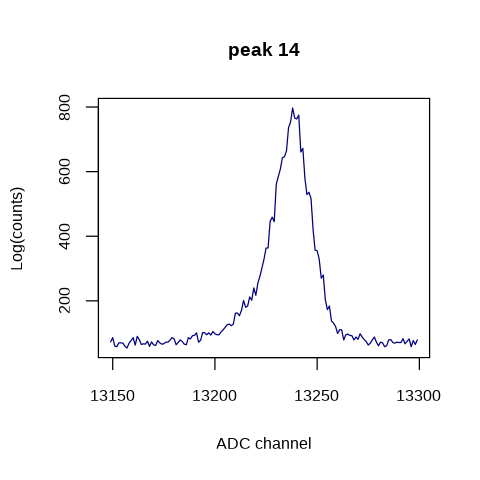

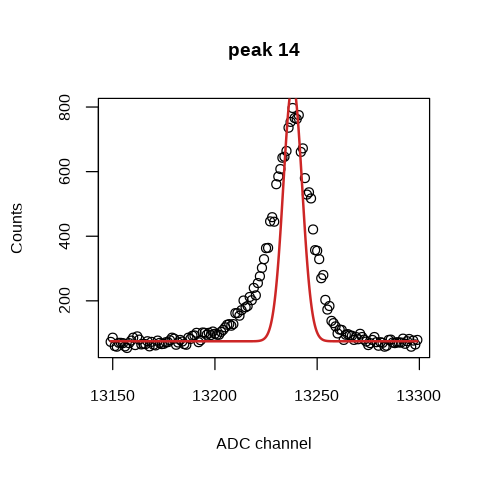

[1] "peak 15"
         mean       std      min_95      max_95
A  7085.27050 0.1391580 7084.997161 7085.541733
B    64.54360 0.2281519   64.104228   64.981112
w     6.44353 0.0200111    6.405051    6.482346
x0    6.44353 0.0200111    6.405051    6.482346


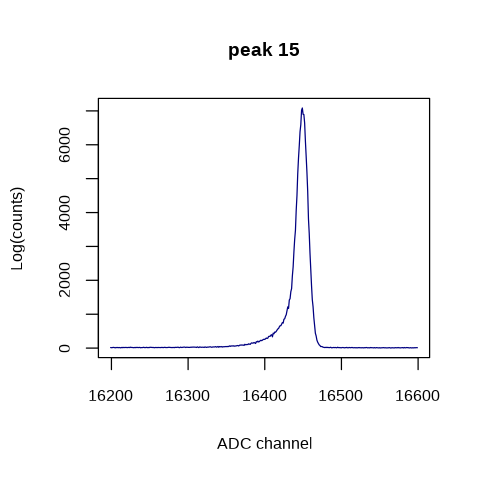

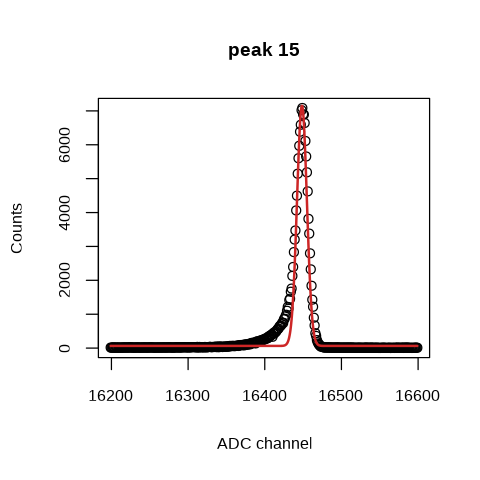

In [76]:
likelihood_str <- 'for (i in 1:length(x)){

S[i] <- (A * dgamma(x[i],x0**2/w**2,x0/w**2) + B)
y[i] ~ dpois(S[i])
}'
priors_str <- function(A.min, A.max, B.max, x0.min, x0.max){
    priors_str <- paste("A ~ dnorm(",A.max,",",50,")
B ~ dnorm(",B.max,",",10,")
x0 ~ dunif(",x0.min,",",x0.max,")
w ~ dunif(1,10)", sep = '')
return(priors_str)
}

T_properties <- peak_properties(th_peaks, likelihood_str, priors_str)

## Energy calibration

In [44]:
df_T$x0_mean <- T_properties$x0_mean
df_T$x0_std  <- T_properties$x0_std
df_T$w_mean  <- T_properties$w_mean
df_T$w_std   <- T_properties$w_std

df_T

T_energies x0_mean   x0_std      w_mean   w_std      
Th 1   238.632    1503.164 0.003010777 2.704313 0.001938908
Th 2   300.089    1890.172 0.013881068 2.755689 0.009396985
Th 3   510.740    3216.230 0.013444651 4.097722 0.008928485
Th 4   583.187    3672.191 0.006952109 3.928637 0.004509703
Th 5   727.330    4579.221 0.018132064 4.352159 0.011551840
Th 6   763.450    4806.365 0.068349125 4.450150 0.048137411
Th 7   785.370    4945.600 0.050619819 4.449739 0.036067610
Th 8   860.530    5417.789 0.026413684 4.771975 0.016926113
Th 9   893.408    5625.066 0.103002756 4.446919 0.072757402
Th 10 1078.630    6791.421 0.098735444 4.910911 0.069074900
Th 11 1512.700    9523.178 0.174192422 5.465889 0.128876809
Th 12 1592.511   10025.994 0.081111853 5.131247 0.053483343
Th 13 1620.738   10201.758 0.081393319 6.059664 0.055072250
Th 14 2103.511   13236.794 0.095618925 9.860510 0.062190451
Th 15 2614.511   16446.596 0.026683105 9.350669 0.017301216

In [45]:
linear_fit <- lm( df_T$T_energies ~ df_T$x0_mean )
summary(linear_fit)$coefficients

intercept     <- summary(linear_fit)$coefficients[1,1]
std_intercept <- summary(linear_fit)$coefficients[1,2]
slope         <- summary(linear_fit)$coefficients[2,1]
std_slope     <-  summary(linear_fit)$coefficients[2,2
                                              ]
#calibrated_energy <- function(x,a,b) a*x+b   

Estimate   Std. Error   t value     Pr(>|t|)    
(Intercept)  -0.6542059 1.754739e-01   -3.728222 2.530244e-03
df_T$x0_mean  0.1589606 2.209247e-05 7195.239994 2.726887e-44

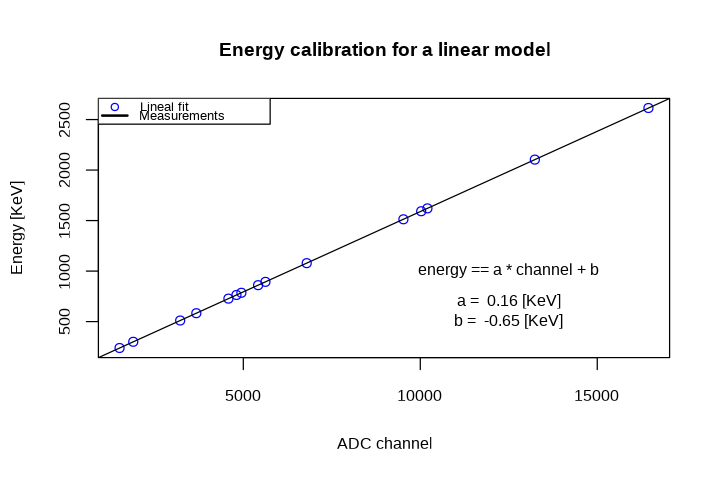

In [46]:
set_plot_dimensions(6, 4)
plot(df_T$x0_mean,df_T$T_energies,col="blue",
    xlab="ADC channel",ylab="Energy [KeV]",
    main="Energy calibration for a linear model")
lines(data_T$Ch,calibrated_energy(data_T$Ch,slope,intercept))
#lines(data_T$Ch,calibrated_energy(data_T$Ch,slope+std_slope,intercept+std_intercept),col="red")
#lines(data_T$Ch,calibrated_energy(data_T$Ch,slope-std_slope,intercept-std_intercept),col="blue")

legend("topleft", legend=c("Lineal fit", "Measurements"),
       col=c("blue","black"), lty=c(0,1),pch=c(1,-1),lwd=c(1,2), cex=0.8)

#text(df_ACC$x0_mean,df_ACC$ACC_energies+c(200,-200,200,200,-200),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(12500, 1000, "energy == a * channel + b")
text(12500, 700, paste("a = ", sprintf("%.2f",slope),"[KeV]"))
text(12500, 500, paste("b = ", sprintf("%.2f",intercept),"[KeV]"))

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”Warning message in xy.coords(x, y, xlabel, ylabel, log):
“4435 y values <= 0 omitted from logarithmic plot”

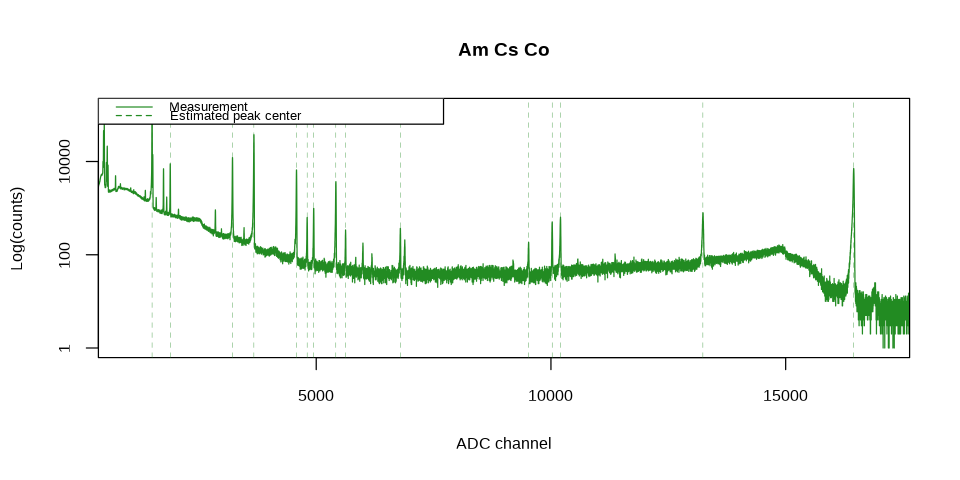

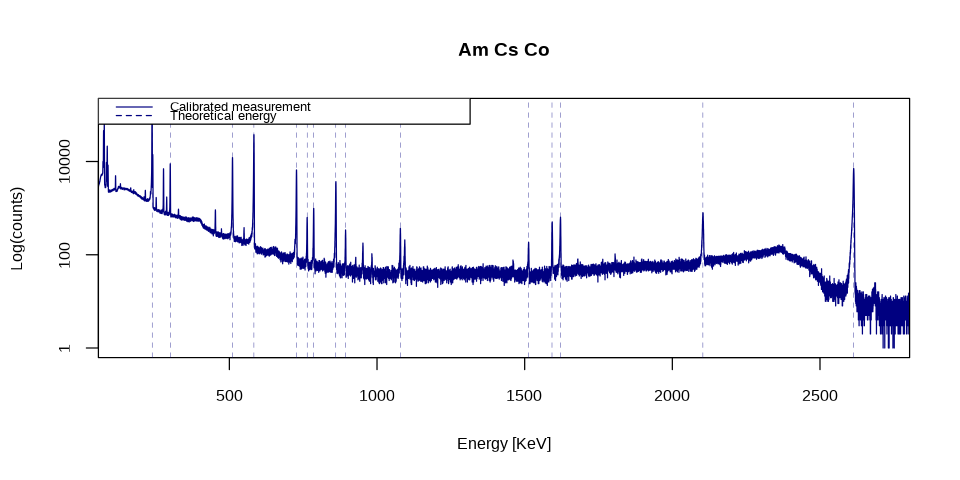

In [47]:
set_plot_dimensions(8, 4)

xmin<-1000;xmax<-17000
emin <- intercept + xmin*slope;  emax<- intercept + xmax*slope

plot(data_T$Ch,data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="forestgreen",
    xlim=c(xmin,xmax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="ADC channel")
for (i in 1:15){
    abline(v=df_T$x0_mean[i],col="forestgreen",lty=2,lwd=0.3)}

legend("topleft", legend=c("Measurement","Estimated peak center"),
       col=c("forestgreen"), lty=1:2, cex=0.8)


plot(calibrated_energy(data_T$Ch,slope,intercept),data_T$counts,log = 'y', type="l",
    pch = 1, cex=0.5, col="navy",
    xlim=c(emin,emax),
    main = "Am Cs Co",
    ylab = "Log(counts)", xlab ="Energy [KeV]")
for (i in 1:15){
    abline(v=df_T$T_energies[i],col="navy",lty=2,lwd=0.3)}
legend("topleft", legend=c("Calibrated measurement","Theoretical energy"),
       col=c("navy"), lty=1:2, cex=0.8)

## Resolution study

In [48]:
df_T

T_energies x0_mean   x0_std      w_mean   w_std      
Th 1   238.632    1503.164 0.003010777 2.704313 0.001938908
Th 2   300.089    1890.172 0.013881068 2.755689 0.009396985
Th 3   510.740    3216.230 0.013444651 4.097722 0.008928485
Th 4   583.187    3672.191 0.006952109 3.928637 0.004509703
Th 5   727.330    4579.221 0.018132064 4.352159 0.011551840
Th 6   763.450    4806.365 0.068349125 4.450150 0.048137411
Th 7   785.370    4945.600 0.050619819 4.449739 0.036067610
Th 8   860.530    5417.789 0.026413684 4.771975 0.016926113
Th 9   893.408    5625.066 0.103002756 4.446919 0.072757402
Th 10 1078.630    6791.421 0.098735444 4.910911 0.069074900
Th 11 1512.700    9523.178 0.174192422 5.465889 0.128876809
Th 12 1592.511   10025.994 0.081111853 5.131247 0.053483343
Th 13 1620.738   10201.758 0.081393319 6.059664 0.055072250
Th 14 2103.511   13236.794 0.095618925 9.860510 0.062190451
Th 15 2614.511   16446.596 0.026683105 9.350669 0.017301216

In [49]:
df_T$FWHM_mean <- 2*sqrt(2*log(2))*T_properties$w_mean
df_T$FWHM_std <- 2*sqrt(2*log(2))*T_properties$w_std

In [50]:
df_Resolution_T <- NULL
df_Resolution_T$x <- df_T$T_energies[1:13]
df_Resolution_T$y <- df_T$FWHM_mean[1:13]

        mean        std    min_95    max_95
w  0.1703203 0.01722246 0.1392091 0.2050387
we 4.0978094 1.27867206 0.8811979 5.9793562


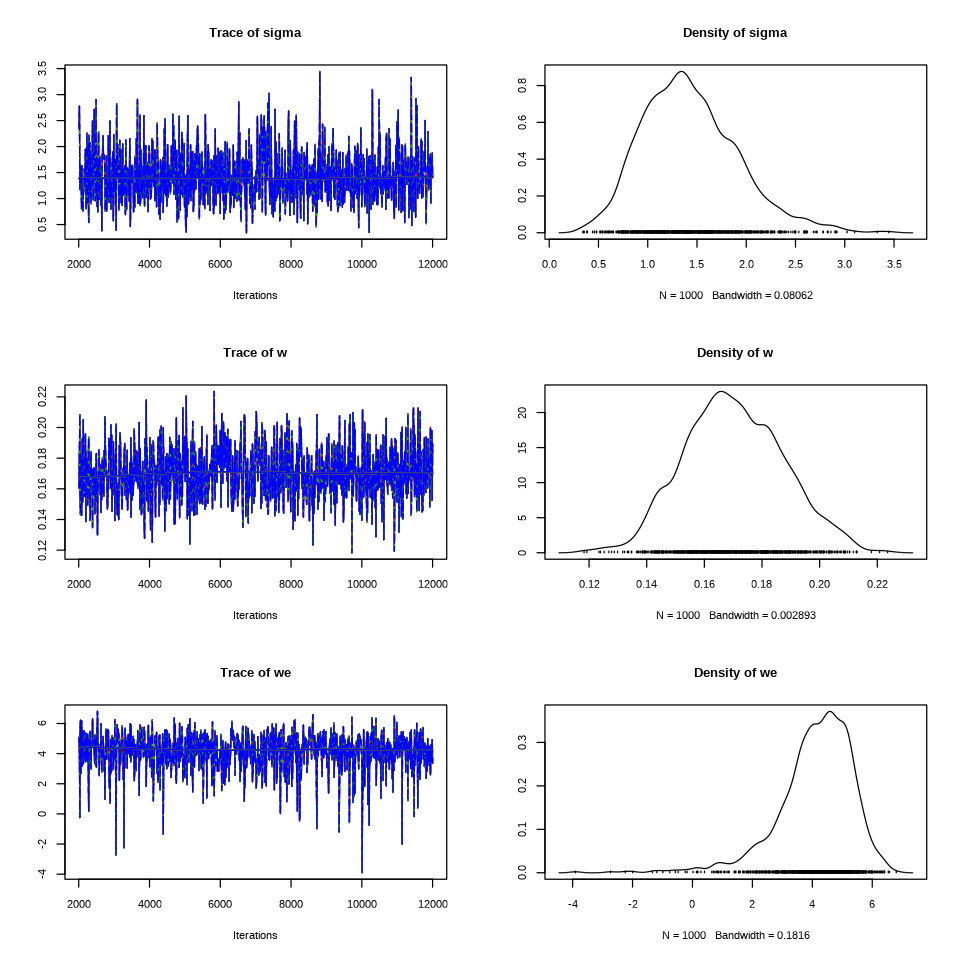

In [51]:
chain <- resolution(df_Resolution_T)

In [52]:
w      <- summary(chain)$statistics[2,1]; sw    <-  summary(chain)$statistics[2,2]
we     <- summary(chain)$statistics[3,1]; swe   <-  summary(chain)$statistics[3,2]
wmin   <- summary(chain)$quantiles[2,1];  wmax  <-  summary(chain)$quantiles[2,5]
wemin  <- summary(chain)$quantiles[3,1];  wemax <-  summary(chain)$quantiles[3,5]
w
we

[1] 0.1703203

[1] 4.097809

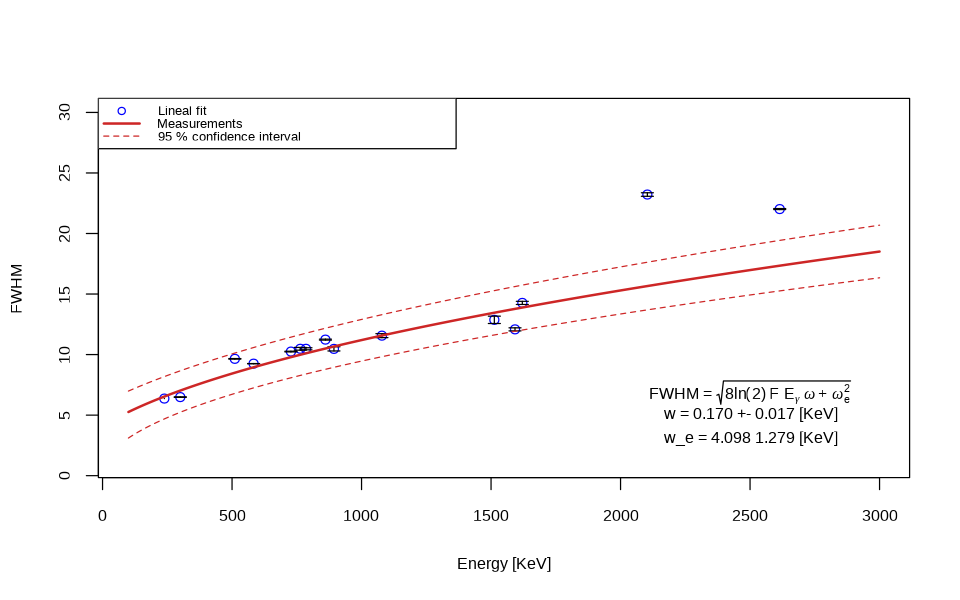

In [53]:
fano <-0.115
    
x <- seq(100,3000,1)
f <- function(x,w,we){return(sqrt(4*2*log(2) * fano * x * w + we**2))}
#f <- sqrt(0.007 * x  + 2.97**2)



set_plot_dimensions(8, 5)
plot(df_T$T_energies,df_T$FWHM_mean,col="blue",
    xlim=c(100,3000), ylim=c(1,30), 
    xlab="Energy [KeV]",ylab="FWHM",
    main="")

arrows(df_T$T_energies, df_T$FWHM_mean-df_T$FWHM_std,
       df_T$T_energies, df_T$FWHM_mean+df_T$FWHM_std,
       length=0.05, angle=90, code=3)

lines(x,f(x,w,we), lwd=2, col='firebrick3')
lines(x,f(x,wmin,wemin), lwd=1,lty=2, col='firebrick3')
lines(x,f(x,wmax,wemax), lwd=1,lty=2, col='firebrick3')

legend("topleft", legend=c("Lineal fit", "Measurements","95 % confidence interval"),
       col=c("blue","firebrick3","firebrick3"), lty=c(0,1,2),pch=c(1,-1,-1),lwd=c(1,2,1), cex=0.8)

#text(df_T$T_energies,df_T$FWHM_mean+c(rep(0.5,5)),c("Am","Cs","Co 1","Co 2","Co 3"),col="blue") 
text(2500, 7,TeX("FWHM = $\\sqrt{8ln(2)\\,F\\,E_{\\gamma} \\,\\omega + \\omega_e^2}$"))
text(2500, 5, paste("w =", sprintf("%.3f",w),"+-",sprintf("%.3f",sw),"[KeV]"))
text(2500, 3, paste("w_e =", sprintf("%.3f",we),sprintf("%.3f",swe),"[KeV]"))